In [1]:
import pandas as pd
import numpy as np
import math
import time
import datetime as dt
import datetime
from scipy.stats import poisson
from scipy.stats import binom
from scipy.stats import nbinom
import sys

import random

# -*- coding: utf-8 -*-

from scipy.sparse import csr_matrix
from matplotlib.colors import hsv_to_rgb , rgb_to_hsv, LinearSegmentedColormap #,LogNorm, LinearSegmentedColormap, ListedColormap, BoundaryNorm
import pickle
import warnings
import matplotlib.pyplot as plt

PYTHON3 = sys.version_info[0] >= 3

# load HTML engine, if it exists
try:
    if __IPYTHON__:
        from IPython.core.display import HTML
    else:
        HTML = lambda x : x
except NameError:
    HTML = lambda x : x

In [2]:
#########################################################################################

#compute median and CI

def add_median_CI(DF):
    df = DF.copy()
    df['p1'] = df[[i for i in range(n_runs)]].quantile(0.025, axis=1)
    df['median'] = df[[i for i in range(n_runs)]].median(axis=1)
    df['p2'] = df[[i for i in range(n_runs)]].quantile(0.975, axis=1)
    return df

#########################################################################################

# functions to read and manipulate the matrix

#reshape the array in a 4x4 matrix
def keep(df):
    C = []
    for i in range(ages*ages):
        c = df[0][i]
        C.append(c)
    C = np.array(C)
    C = np.reshape(C, (ages,ages))
    return C

#construct the four contact matrices
def extract_matrix(matrix, x_test_a,x_test_s):
    wd = keep(matrix) # healthy behavior (matrix for the individuals in the prodromic phase)
    wd_as = x_test_a*keep(matrix)*0.1 + (1-x_test_a)*keep(matrix)      # asymptomatic
    wd_t = x_test_s*keep(matrix)*0.1 + (1-x_test_s)*keep(matrix)       # pauci-symptomatic and mild
    wd_s = x_test_s*keep(matrix)*0.1 + (1-x_test_s)*keep(matrix)*0.25  # severe symptoms

    return wd,wd_as,wd_t,wd_s

#########################################################################################

def seir(u, parms, t, intervention,     #intervention is a boolean that activates LD1 and the exit strategies 
         LD, TW, scale1, scale2,
         BS_wd, BS_wd_as, BS_wd_t, BS_wd_s,   #matrices for the pre-pandemic phase
         LD_wd, LD_wd_as, LD_wd_t, LD_wd_s,
         TW_wd, TW_wd_as, TW_wd_t, TW_wd_s,   #(list of) weekly matrices for the exit phase (from May 11) 
         projections, proj_scenario, numero_run,
         ordered_run_initialization):

    #quantities of interest
    S = u['S']

    new_E = u['Y_E']
    E = u['E']
    new_I_p = u['Y_I_p']
    I_p = u['I_p']
    new_I_as = u['Y_I_as']
    I_as = u['I_as']
    new_I_ps = u['Y_I_ps']
    I_ps = u['I_ps']
    new_I_ms = u['Y_I_ms']
    I_ms = u['I_ms']
    new_I_ss = u['Y_I_ss']
    I_ss = u['I_ss']
    new_W = u['Y_W']
    W = u['W']
    new_H = u['Y_H']
    H = u['H']
    new_R = u['Y_R']
    R = u['R']
    new_V = u['Y_V']
    
    N_tot = u['N_tot']

    bet, sigm, thet, gamm, N, dt = parms
    
    # baseline scenario
    C_h = BS_wd*seasonal[t]
    C_as = BS_wd_as*seasonal[t]
    C_t = BS_wd_t*seasonal[t]
    C_s = BS_wd_s*seasonal[t]
                                      
    if intervention:        
        for week in weeks:
            stage0_start = TW[week][0]
            stage0_end = TW[week][1]

            if (t >= stage0_start) and (t < stage0_end):
                C_h = TW_wd[week]*scale2[week]*seasonal[t]
                C_as = TW_wd_as[week]*scale2[week]*seasonal[t]
                C_t = TW_wd_t[week]*scale2[week]*seasonal[t]
                C_s = TW_wd_s[week]*scale2[week]*seasonal[t]
                
        if t>=TW[weeks[-1]][1]:
            C_h = TW_wd[weeks[-1]]*scale2[weeks[-1]]*seasonal[t]
            C_as = TW_wd_as[weeks[-1]]*scale2[weeks[-1]]*seasonal[t]
            C_t = TW_wd_t[weeks[-1]]*scale2[weeks[-1]]*seasonal[t]
            C_s = TW_wd_s[weeks[-1]]*scale2[weeks[-1]]*seasonal[t]
            
        #if t>=start_scenario:
        #    C_h = TW_wd['summer']*scale2[week_summer]*R0_target/R0_origin
        #    C_as = TW_wd_as['summer']*scale2[week_summer]*R0_target/R0_origin
        #    C_t = TW_wd_t['summer']*scale2[week_summer]*R0_target/R0_origin
        #   C_s = TW_wd_s['summer']*scale2[week_summer]*R0_target/R0_origin
           
            #if t == start_scenario:
            #    print(TW_wd['summer'], scale2[week_summer])
                
    # situation at the previous timestep
    lambd = {}
    
    for variant in variants:
        for past in past_infection[variant]:
            for status_vax in stati_vax:
                strain = past+variant+'_'+status_vax
                lambd[strain]=[0]*ages
            
    eta={}
    
    for variant in variants:
        for past in past_infection[variant]:
            for status_vax in stati_vax:   
                strain = past+variant+'_'+status_vax
                eta[strain]=[0]*ages
                for age in range(ages):
                    eta[strain][age]=trans_increase_time[variant][t]*(1.0-VE_trans[strain])
                    ## if you want you mat define VE_trans[strain][age]
    
    for variant in variants:
        for past in past_infection[variant]:
            for status_vax in stati_vax:   
                strain = past+variant+'_'+status_vax
                for age in range(ages):
                    l = 0
                    for age2 in range(ages):
                        l += eta[strain][age2]*susc[variant][age]*r[age2]*bet*C_h[age,age2]*I_p[strain][age2]/N
                        l += eta[strain][age2]*susc[variant][age]*r[age2]*bet*C_as[age,age2]*I_as[strain][age2]/N
                        l += eta[strain][age2]*susc[variant][age]*r[age2]*bet*C_t[age,age2]*I_ps[strain][age2]/N
                        l += eta[strain][age2]*susc[variant][age]*bet*C_t[age,age2]*I_ms[strain][age2]/N
                        l += eta[strain][age2]*susc[variant][age]*bet*C_s[age,age2]*I_ss[strain][age2]/N
                    lambd[strain][age] = l
                lambd[strain] = np.array(lambd[strain])
                ## QUI STRAIN é l'INFETTORE che trasmette l'infezione
                ## lambd[strain] is a vector with length ages
                ## lambd[strain][age] represents the force of infection on S['dose0'][age]
                ## given by all ages in infectious compartments of a given strain=past+variant+status_vax
                ## e.g. strain = 'delta_dose1', then lambd[strain] is the vector of force of infection
                ## on susceptible (non vaccinated) individuals of each age class 
                ## produced by infectious individuals of any age 
                ## with delta variant and 1 dose of vaccination
    
    # compute transition probabilities for entering in each comparment
    
    in_E = {}
    
    for variant in variants:
        ## for each variant (delta or omicron), 
        ## I compute the total force of infection, summing over all vaccination stati and past infections
        tot_lambd = 0
        
        for past in past_infection[variant]:
            for status_vax in stati_vax:
                strain = past+variant+'_'+status_vax 
                tot_lambd += lambd[strain]
                ## tot_lambd is a vector with length ages
                ## tot_lambd[age] represents the force of infection on S['dose0'][age]
                ## given by all ages in infectious compartments of a given variant
                ## summing over all possible vaccination status and past infections    
                                                              
        for past in past_infection[variant]:
            for status_vax in stati_vax:
                strain = past+variant+'_'+status_vax
                tot_lambd_vax = [0]*ages
                for age in range(ages):
                    tot_lambd_vax[age] = tot_lambd[age]*(1.0-VE_infect[strain])
                tot_lambd_vax = np.array(tot_lambd_vax)
                in_E[strain] = 1.0 - np.exp(-tot_lambd_vax*dt)        
                                         
                ## QUI STRAIN é il SUSCETTIBILE che riceve l'infezione
                ## in_E[strain] is a vector with length ages
                ## in_E[strain][age] represents the force of infection on S[status_vax][age]
                ## given by all ages in infectious compartments of a given strain
                ## e.g. strain = 'delta_dose1', then in_E['delta_dose1'] is the vector of force of infection
                ## on S[status_vax][age] individuals of each age class 
                ## produced by infectious individuals of any age or vaccination status with delta variant

    in_I_p={}
    in_I={}
    in_R={}
    in_W={}
    in_H={}
    in_R_from_H={}
    
    for variant in variants:
        for past in past_infection[variant]:
            for status_vax in stati_vax:
                strain = past+variant+'_'+status_vax
        
                #in_I_p[strain]=np.array([sigm*dt]*ages)
                in_I[strain]=np.array([thet*dt]*ages)
                in_R[strain]=np.array([gamm*dt]*ages)

                in_W[strain]=np.array([gamm*dt]*ages)
                in_H[strain]=np.array([rate_w*dt]*ages)
                in_R_from_H[strain]=np.array([rate_hosp*dt]*ages)

                in_I_p[strain] = np.array([sigm[variant]*dt]*ages)

    # transition events (sampled by binomial or multinomial distributions with corresponding transition probabilities)
    
    # infections events
    for age in range(ages):
        for status_vax in stati_vax:
            
            # first infections
            force_of_infection = [] 
            
            for variant in variants:
                for past in ['']:
                    strain = past+variant+'_'+status_vax
                    force_of_infection.append(in_E[strain][age])  
                    
            complem = sum(force_of_infection)
            force_of_infection.append(1.0-complem)
            force_of_infection = np.array(force_of_infection)
                    
            infections = np.random.multinomial(S[status_vax][age],force_of_infection)
            
            for j,variant in enumerate(variants):
                for past in ['']:
                    strain = past+variant+'_'+status_vax
                    new_E[strain][age] = infections[j]
                    
            # re-infections Delta-Omicron
            # full protection
            force_of_reinfection = []
                    
            for variant in ['omicron']: 
                for past in ['delta-']:  
                    strain = past+variant+'_'+status_vax
                    force_of_reinfection.append(in_E[strain][age])
            
            complem_re = sum(force_of_reinfection)
            force_of_reinfection.append(1.0-complem_re)
            force_of_reinfection = np.array(force_of_reinfection)
            
            reinfections = np.random.multinomial(R['delta_'+status_vax][age],force_of_reinfection)
                    
            for j,variant in enumerate(['omicron']):
                for past in ['delta-']:
                    strain = past+variant+'_'+status_vax
                    new_E[strain][age] = reinfections[j]
           
            # re-infections Delta-Omicron
            # waned protection  
            force_of_reinfection = []
 
            for variant in ['omicron']: 
                for past in ['delta-waned-']:  
                    strain = past+variant+'_'+status_vax
                    force_of_reinfection.append(in_E[strain][age])
            
            complem_re = sum(force_of_reinfection)
            force_of_reinfection.append(1.0-complem_re)
            force_of_reinfection = np.array(force_of_reinfection)
            
            reinfections = np.random.multinomial(R['delta-waned_'+status_vax][age],force_of_reinfection)
                    
            for j,variant in enumerate(['omicron']):
                for past in ['delta-waned-']:
                    strain = past+variant+'_'+status_vax
                    new_E[strain][age] = reinfections[j]
                
            # re-infections Omicron-Omicron
            force_of_reinfection = []
                    
            for variant in ['omicron']: 
                for past in ['omicron-']:  
                    strain = past+variant+'_'+status_vax
                    force_of_reinfection.append(in_E[strain][age])
            
            complem_re = sum(force_of_reinfection)
            force_of_reinfection.append(1.0-complem_re)
            force_of_reinfection = np.array(force_of_reinfection)
            
            reinfections = np.random.multinomial(R['omicron_'+status_vax][age],force_of_reinfection)
                    
            for j,variant in enumerate(['omicron']):
                for past in ['omicron-']:
                    strain = past+variant+'_'+status_vax
                    new_E[strain][age] = reinfections[j]
        
    #spontaneous transitions
    
    recovery_as = {}
    recovery_ps = {}
    recovery_ms = {}
    recovery_h = {}
    
    if t < wild_origin:
        list_strains=[]
    else:
        list_strains=[]
        for variant in variants:
            for past in past_infection[variant]:
                for status_vax in stati_vax:
                    strain = past+variant+'_'+status_vax
                    list_strains.append(strain)
        
    for strain in list_strains:
        recovery_as[strain] = [0]*ages
        recovery_ps[strain] = [0]*ages
        recovery_ms[strain] = [0]*ages
        recovery_h[strain] = [0]*ages
        
        for age in range(ages):
            new_I_p[strain][age] = np.random.binomial(E[strain][age],in_I_p[strain][age])

            trans_I = np.array([p_as_v[strain][age]*in_I[strain][age], 
                                p_ps_v[strain][age]*in_I[strain][age], 
                                p_ms_v[strain][age]*in_I[strain][age], 
                                p_ss_v[strain][age]*in_I[strain][age], 
                                1.-in_I[strain][age]])
            #print(trans_I)
            new_I_as[strain][age], new_I_ps[strain][age], new_I_ms[strain][age], new_I_ss[strain][age], res = np.random.multinomial(I_p[strain][age],trans_I)

            recovery_as[strain][age] = np.random.binomial(I_as[strain][age],in_R[strain][age])
            recovery_ps[strain][age] = np.random.binomial(I_ps[strain][age],in_R[strain][age])
            recovery_ms[strain][age] = np.random.binomial(I_ms[strain][age],in_R[strain][age])

            new_W[strain][age] = np.random.binomial(I_ss[strain][age],in_W[strain][age])
            new_H[strain][age] = np.random.binomial(W[strain][age],in_H[strain][age])
            recovery_h[strain][age] = np.random.binomial(H[strain][age], in_R_from_H[strain][age])
            
            new_R[strain][age] = recovery_as[strain][age] + recovery_ps[strain][age] + recovery_ms[strain][age] + recovery_h[strain][age]

    #update compartments
    
    for age in range(ages):  
        
        for status_vax in stati_vax:
            
            # first infections exiting from S
            exit_S = 0
            for variant in variants:
                for past in ['']:
                    strain = past+variant+'_'+status_vax
                    exit_S += new_E[strain][age]
                    
            S[status_vax][age] = S[status_vax][age] - exit_S
            
            # re-infection exiting from R delta
            exit_R = 0
            for variant in [variants[1]]:
                for past in ['delta-']:
                    strain = past+variant+'_'+status_vax
                    exit_R += new_E[strain][age]
        
            R['delta_'+status_vax][age] = R['delta_'+status_vax][age] - exit_R
            
            exit_R = 0
            for variant in [variants[1]]:
                for past in ['delta-waned-']:
                    strain = past+variant+'_'+status_vax
                    exit_R += new_E[strain][age]
        
            R['delta-waned_'+status_vax][age] = R['delta-waned_'+status_vax][age] - exit_R
            
            # re-infection exiting from R omicron
            exit_R = 0
            for variant in [variants[1]]:
                for past in ['omicron-']:
                    strain = past+variant+'_'+status_vax
                    exit_R += new_E[strain][age]
                    
            R['omicron_'+status_vax][age] = R['omicron_'+status_vax][age] - exit_R

        for strain in list_strains:      
            E[strain][age] = E[strain][age] + new_E[strain][age] - new_I_p[strain][age]
            I_p[strain][age] = I_p[strain][age] + new_I_p[strain][age] - new_I_as[strain][age] - new_I_ps[strain][age] - new_I_ms[strain][age] - new_I_ss[strain][age]
            I_as[strain][age] = I_as[strain][age] + new_I_as[strain][age] - recovery_as[strain][age]
            I_ps[strain][age] = I_ps[strain][age] + new_I_ps[strain][age] - recovery_ps[strain][age]
            I_ms[strain][age] = I_ms[strain][age] + new_I_ms[strain][age] - recovery_ms[strain][age]
            I_ss[strain][age] = I_ss[strain][age] + new_I_ss[strain][age] - new_W[strain][age]
            W[strain][age] = W[strain][age] + new_W[strain][age] - new_H[strain][age]
            H[strain][age] = H[strain][age] + new_H[strain][age] - recovery_h[strain][age]
            R[strain][age] = R[strain][age] + new_R[strain][age]

    if t == wild_origin: ## t == wild origin == VOC_origin
        
        if ordered_run_initialization == False:        
            indice = casuale[numero_run]
        else:
            indice = numero_run
        
        dict_config_wild = dict(config_wild.iloc[numero_run])
        
        for age in range(ages):
            
            for status_vax in stati_vax:
                
                if status_vax not in ['dose3-waned-1', 'dose3-waned-2', 'dose3-waned-3']:
                
                    source = status_vax
                    strain = 'delta_'+status_vax
                    E[strain][age] = int(np.around(dict_config_wild['E_age{}_{}'.format(age,source)]))
                    I_p[strain][age] = int(np.around(dict_config_wild['I_p_age{}_{}'.format(age,source)]))
                    I_as[strain][age] = int(np.around(dict_config_wild['I_as_age{}_{}'.format(age,source)]))
                    I_ps[strain][age] = int(np.around(dict_config_wild['I_ps_age{}_{}'.format(age,source)]))
                    I_ms[strain][age] = int(np.around(dict_config_wild['I_ms_age{}_{}'.format(age,source)]))
                    I_ss[strain][age] = int(np.around(dict_config_wild['I_ss_age{}_{}'.format(age,source)]))
                    W[strain][age] = int(np.around(dict_config_wild['W_age{}_{}'.format(age,source)]))
                    H[strain][age] = int(np.around(dict_config_wild['H_age{}_{}'.format(age,source)]))
                    R[strain][age] = int(np.around(dict_config_wild['R_age{}_{}'.format(age,source)]))

                    S[status_vax][age] = int(np.around(dict_config_wild['S_age{}_{}'.format(age,status_vax)])) 
                
                elif status_vax == 'dose3-waned-1':
                    
                    source = 'dose3-waned'
                    strain = 'delta_'+status_vax
                    E[strain][age] = int(np.around(dict_config_wild['E_age{}_{}'.format(age,source)]))
                    I_p[strain][age] = int(np.around(dict_config_wild['I_p_age{}_{}'.format(age,source)]))
                    I_as[strain][age] = int(np.around(dict_config_wild['I_as_age{}_{}'.format(age,source)]))
                    I_ps[strain][age] = int(np.around(dict_config_wild['I_ps_age{}_{}'.format(age,source)]))
                    I_ms[strain][age] = int(np.around(dict_config_wild['I_ms_age{}_{}'.format(age,source)]))
                    I_ss[strain][age] = int(np.around(dict_config_wild['I_ss_age{}_{}'.format(age,source)]))
                    W[strain][age] = int(np.around(dict_config_wild['W_age{}_{}'.format(age,source)]))
                    H[strain][age] = int(np.around(dict_config_wild['H_age{}_{}'.format(age,source)]))
                    R[strain][age] = int(np.around(dict_config_wild['R_age{}_{}'.format(age,source)]))

                    S[status_vax][age] = int(np.around(dict_config_wild['S_age{}_{}'.format(age,source)])) 
                    
                else:
                    
                    source = status_vax
                    strain = 'delta_'+status_vax
                    E[strain][age] = 0
                    I_p[strain][age] = 0
                    I_as[strain][age] = 0
                    I_ps[strain][age] = 0
                    I_ms[strain][age] = 0
                    I_ss[strain][age] = 0
                    W[strain][age] = 0
                    H[strain][age] = 0
                    R[strain][age] = 0

                    S[status_vax][age] = 0                   
                
                    
    if t == VOC_origin:
        
        for age in range(ages):
        
            for status_vax in stati_vax:

                variant = 'delta'
                strain = variant+'_'+status_vax

                E_tot = E[strain][age]
                I_p_tot = I_p[strain][age]
                I_as_tot = I_as[strain][age]
                I_ps_tot = I_ps[strain][age]
                I_ms_tot = I_ms[strain][age]
                I_ss_tot = I_ss[strain][age]
                H_tot = H[strain][age]
                R_tot = R[strain][age]

                variant = 'delta'
                strain = variant+'_'+status_vax

                E[strain][age] = int(np.around(E_tot*(1.-prev_omicron)))
                I_p[strain][age] = int(np.around(I_p_tot*(1.-prev_omicron)))
                I_as[strain][age] = int(np.around(I_as_tot*(1.-prev_omicron)))
                I_ps[strain][age] = int(np.around(I_ps_tot*(1.-prev_omicron)))
                I_ms[strain][age] = int(np.around(I_ms_tot*(1.-prev_omicron)))
                I_ss[strain][age] = int(np.around(I_ss_tot*(1.-prev_omicron)))
                H[strain][age] = int(np.around(H_tot*(1.-prev_omicron)))
                R[strain][age] = int(np.around(R_tot*(1.-prev_omicron)))    

                variant = 'omicron'
                strain = variant+'_'+status_vax

                E[strain][age] = int(np.around(E_tot*(prev_omicron)))
                I_p[strain][age] = int(np.around(I_p_tot*(prev_omicron)))
                I_as[strain][age] = int(np.around(I_as_tot*(prev_omicron)))
                I_ps[strain][age] = int(np.around(I_ps_tot*(prev_omicron)))
                I_ms[strain][age] = int(np.around(I_ms_tot*(prev_omicron)))
                I_ss[strain][age] = int(np.around(I_ss_tot*(prev_omicron)))
                H[strain][age] = int(np.around(H_tot*(prev_omicron)))
                R[strain][age] = int(np.around(R_tot*(prev_omicron)))
          
            prior_infected = 0
            for status_vax in stati_vax:
                prior_infected += R['delta_'+status_vax][age]

            prop_waned_imm = infected_with_waned_imm[age]/prior_infected
            #print(age, prop_waned_imm)

            for status_vax in stati_vax:
                ### individuals with past infection with waned immunity (>6 months prior infection)
                #print(age, status_vax, R['delta_'+status_vax][age])
                R['delta-waned_'+status_vax][age] = int(prop_waned_imm*R['delta_'+status_vax][age])
                R['delta_'+status_vax][age] = R['delta_'+status_vax][age] - R['delta-waned_'+status_vax][age]
                
                #print(age, status_vax, R['delta_'+status_vax][age], R['delta-waned_'+status_vax][age])
                
    #VACCINATION
    if t > wild_origin:
        # continue with vaccination
        # administer doses according to data
        one_week=7
        
        for age in [0,1,2,3]:
            for i, week in enumerate(np.arange(weeks[0], weeks[-1]+100)):
                stage0_start = i*one_week+1
                stage0_end = (i+1)*one_week+1
                
                if (t >= stage0_start) and (t < stage0_end):
                    current_week = week 
                    break
                    
            if (current_week >= start_week_vaccine_proj+vax_delay_eff):
                print('define how to deal with projections of vaccines')
                sys.exit()
                # TRANSIT FROM FIRTS DOSE TO SECOND DOSE COMPARTMENT 
                #in_exit_vax = 1./(7*projected_delay_inter_doses)  ## 3 weeks average time between first dose and second dose in the projected scenarios
                #exit_vax  = np.random.binomial(S['dose1'][age],in_exit_vax)
                #S['dose1'][age]=S['dose1'][age]-exit_vax
                #new_V['dose2-full'][age] += exit_vax
                #S['dose2-full'][age]=S['dose2-full'][age]+exit_vax
                #exit_vax  = np.random.binomial(R['Alpha_dose1'][age],in_exit_vax)
                #R['Alpha_dose1'][age]=R['Alpha_dose1'][age]-exit_vax
                #new_V['dose2-full'][age] += exit_vax
                #R['Alpha_dose2-full'][age]=R['Alpha_dose2-full'][age]+exit_vax
                #exit_vax  = np.random.binomial(R['Delta_dose1'][age],in_exit_vax)
                #R['Delta_dose1'][age]=R['Delta_dose1'][age]-exit_vax
                #new_V['dose2-full'][age] += exit_vax
                #R['Delta_dose2-full'][age]=R['Delta_dose2-full'][age]+exit_vax       

            else: 
                if age == 0:
                    N_age = N_c
                    max_cov = max_coverage['child']
                    tag_age = 'child'                  
                elif age == 1: 
                    N_age = N_t
                    max_cov = max_coverage['teen']
                    tag_age = 'teen'
                elif age == 2: 
                    N_age = N_a
                    max_cov = max_coverage['adu']
                    tag_age = 'adult'
                elif age == 3:
                    N_age = N_s
                    max_cov = max_coverage['sen']
                    tag_age = 'senior'
                else:
                    sys.exit()

                new_doses = {}

                condition = past_rollout['date_vax']==(calendar.iloc[t][0]-datetime.timedelta(days=vax_delay_eff*7))
                new_doses['dose1'] = int((N_age/100.)*past_rollout[condition]['%_{}_1d'.format(tag_age)].values[0])

                condition = past_rollout['date_vax']==(calendar.iloc[t][0]-datetime.timedelta(days=vax_delay_waning_3*7))
                new_doses['dose2-waned-3'] = int((N_age/100.)*past_rollout[condition]['%_{}_2d'.format(tag_age)].values[0])

                condition = past_rollout['date_vax']==(calendar.iloc[t][0]-datetime.timedelta(days=vax_delay_waning_2*7))
                new_doses['dose2-waned-2'] = int((N_age/100.)*past_rollout[condition]['%_{}_2d'.format(tag_age)].values[0])

                condition = past_rollout['date_vax']==(calendar.iloc[t][0]-datetime.timedelta(days=vax_delay_waning_1*7))
                new_doses['dose2-waned-1'] = int((N_age/100.)*past_rollout[condition]['%_{}_2d'.format(tag_age)].values[0])

                condition = past_rollout['date_vax']==(calendar.iloc[t][0]-datetime.timedelta(days=vax_delay_eff*7))
                new_doses['dose2-full'] = int((N_age/100.)*past_rollout[condition]['%_{}_2d'.format(tag_age)].values[0])

                condition = past_rollout['date_vax']==(calendar.iloc[t][0]-datetime.timedelta(days=vax_delay_booster_waning_3*7))
                new_doses['dose3-waned-3'] = int((N_age/100.)*past_rollout[condition]['%_{}_3d'.format(tag_age)].values[0])
                
                condition = past_rollout['date_vax']==(calendar.iloc[t][0]-datetime.timedelta(days=vax_delay_booster_waning_2*7))
                new_doses['dose3-waned-2'] = int((N_age/100.)*past_rollout[condition]['%_{}_3d'.format(tag_age)].values[0])
                
                condition = past_rollout['date_vax']==(calendar.iloc[t][0]-datetime.timedelta(days=vax_delay_booster_waning_1*7))
                new_doses['dose3-waned-1'] = int((N_age/100.)*past_rollout[condition]['%_{}_3d'.format(tag_age)].values[0])

                condition = past_rollout['date_vax']==(calendar.iloc[t][0]-datetime.timedelta(days=vax_delay_booster*7))
                new_doses['dose3-full'] = int((N_age/100.)*past_rollout[condition]['%_{}_3d'.format(tag_age)].values[0])

                for status_vax in stati_vax:
                    if status_vax != 'dose0':
                        new_V[status_vax][age]=0     

                perc_vacc_by_dose = {}

                for dose in ['d1', 'd2', 'd3']:
                    if dose == 'd1':
                        list_stati = ['dose1']
                    elif dose == 'd2':
                        #list_stati = ['dose2-full', 'dose2-waned', 'dose2-elig']
                        list_stati = ['dose2-full', 'dose2-waned-1', 'dose2-waned-2', 'dose2-waned-3']
                    elif dose == 'd3':
                        list_stati = ['dose3-full', 'dose3-waned-1', 'dose3-waned-2', 'dose3-waned-3']
                    else:
                        sys.exit()

                    perc_vacc_by_dose[dose] = 0

                    for status_vax in list_stati:
                        perc_vacc_by_dose[dose] += S[status_vax][age]  
                        for variant in variants:
                            for past in past_infection[variant]:
                                perc_vacc_by_dose[dose] += E['{}{}_{}'.format(past,variant,status_vax)][age]
                                perc_vacc_by_dose[dose] += I_p['{}{}_{}'.format(past,variant,status_vax)][age]
                                perc_vacc_by_dose[dose] += I_as['{}{}_{}'.format(past,variant,status_vax)][age]
                                perc_vacc_by_dose[dose] += I_ps['{}{}_{}'.format(past,variant,status_vax)][age]
                                perc_vacc_by_dose[dose] += I_ms['{}{}_{}'.format(past,variant,status_vax)][age]
                                perc_vacc_by_dose[dose] += I_ss['{}{}_{}'.format(past,variant,status_vax)][age]
                                perc_vacc_by_dose[dose] += H['{}{}_{}'.format(past,variant,status_vax)][age]
                                perc_vacc_by_dose[dose] += R['{}{}_{}'.format(past,variant,status_vax)][age]
                        perc_vacc_by_dose[dose]+=R['delta-waned_{}'.format(status_vax)][age]

                perc_vacc_by_dose['d1']=perc_vacc_by_dose['d1']/N_age
                perc_vacc_by_dose['d2']=perc_vacc_by_dose['d2']/N_age
                perc_vacc_by_dose['d3']=perc_vacc_by_dose['d3']/N_age

                perc_vacc = (perc_vacc_by_dose['d1']+perc_vacc_by_dose['d2']+perc_vacc_by_dose['d3'])

                if perc_vacc < max_cov:

                    # FIRST DOSES
                    #print([l for l in R.keys() if 'dose0' in l])
                    vaccinabili = S['dose0'][age]+R['delta_dose0'][age]+R['omicron_dose0'][age]+\
                                            +R['delta-omicron_dose0'][age]+R['omicron-omicron_dose0'][age]+\
                                            +R['delta-waned_dose0'][age]+R['delta-waned-omicron_dose0'][age]

                    trans_vax = np.array([S['dose0'][age]/float(vaccinabili), 
                                            R['delta_dose0'][age]/float(vaccinabili), 
                                            R['omicron_dose0'][age]/float(vaccinabili),
                                            R['delta-omicron_dose0'][age]/float(vaccinabili),
                                            R['omicron-omicron_dose0'][age]/float(vaccinabili),
                                            R['delta-waned_dose0'][age]/float(vaccinabili),
                                            R['delta-waned-omicron_dose0'][age]/float(vaccinabili),0])

                    if (perc_vacc*N_age + new_doses['dose1']) < max_cov*N_age:
                        new_S_vax, new_R_wild_vax, new_R_VOC_vax, \
                            new_R_wild_reinf_vax, new_R_VOC_reinf_vax, \
                            new_R_wild_waned_vax, new_R_VOC_waned_vax, \
                                res = np.random.multinomial(new_doses['dose1'], trans_vax)
                    else:
                        doses_ad_hoc = int(max_cov*N_age - perc_vacc*N_age) # which is a smaller value than new_1st_doses
                        new_S_vax, new_R_wild_vax, new_R_VOC_vax, \
                            new_R_wild_reinf_vax, new_R_VOC_reinf_vax, \
                            new_R_wild_waned_vax, new_R_VOC_waned_vax, \
                                res = np.random.multinomial(doses_ad_hoc, trans_vax)

                    vax = min(new_S_vax, S['dose0'][age])
                    new_V['dose1'][age] += vax
                    S['dose0'][age] -= vax
                    S['dose1'][age] += vax
                    
                    vax = min(new_R_wild_vax,R['delta_dose0'][age])
                    new_V['dose1'][age] += vax
                    R['delta_dose0'][age] -= vax
                    R['delta_dose1'][age] += vax

                    vax = min(new_R_VOC_vax,R['omicron_dose0'][age])
                    new_V['dose1'][age] += vax
                    R['omicron_dose0'][age] -= vax
                    R['omicron_dose1'][age] += vax
                    
                    vax = min(new_R_wild_reinf_vax,R['delta-omicron_dose0'][age])
                    new_V['dose1'][age] += vax
                    R['delta-omicron_dose0'][age] -= vax
                    R['delta-omicron_dose1'][age] += vax
                    
                    vax = min(new_R_VOC_reinf_vax,R['omicron-omicron_dose0'][age])
                    new_V['dose1'][age] += vax
                    R['omicron-omicron_dose0'][age] -= vax
                    R['omicron-omicron_dose1'][age] += vax
                    
                    vax = min(new_R_wild_waned_vax,R['delta-waned_dose0'][age])
                    new_V['dose1'][age] += vax
                    R['delta-waned_dose0'][age] -= vax
                    R['delta-waned_dose1'][age] += vax
                    
                    vax = min(new_R_VOC_waned_vax,R['delta-waned-omicron_dose0'][age])
                    new_V['dose1'][age] += vax
                    R['delta-waned-omicron_dose0'][age] -= vax
                    R['delta-waned-omicron_dose1'][age] += vax

                    # OTHER DOSES
                    dict_source = dict(zip(stati_vax[2:],stati_vax[1:-1]))

                    for status_vax in dict_source.keys():

                        source = dict_source[status_vax]

                        vaccinabili = S[source][age]+R['delta_{}'.format(source)][age]+\
                                                R['omicron_{}'.format(source)][age]+\
                                                R['delta-omicron_{}'.format(source)][age]+\
                                                R['omicron-omicron_{}'.format(source)][age]+\
                                                R['delta-waned_{}'.format(source)][age]+\
                                                R['delta-waned-omicron_{}'.format(source)][age]

                        if vaccinabili > 0 :
                            
                            trans_vax = np.array([S[source][age]/float(vaccinabili), 
                                                R['delta_{}'.format(source)][age]/float(vaccinabili), 
                                                R['omicron_{}'.format(source)][age]/float(vaccinabili),
                                                R['delta-omicron_{}'.format(source)][age]/float(vaccinabili),
                                                R['omicron-omicron_{}'.format(source)][age]/float(vaccinabili),
                                                R['delta-waned_{}'.format(source)][age]/float(vaccinabili),
                                                R['delta-waned-omicron_{}'.format(source)][age]/float(vaccinabili),0])
                            
                            #print(t,status_vax,trans_vax)

                            new_S_vax, new_R_wild_vax, new_R_VOC_vax, \
                            new_R_wild_reinf_vax, new_R_VOC_reinf_vax, \
                            new_R_wild_waned_vax, new_R_VOC_waned_vax, \
                                res = np.random.multinomial(new_doses[status_vax], trans_vax)

                            vax = min(new_S_vax, S[source][age])
                            new_V[status_vax][age] += vax
                            S[source][age] -= vax
                            S[status_vax][age] += vax
                            
                            vax = min(new_R_wild_vax,R['delta_{}'.format(source)][age])
                            new_V[status_vax][age] += vax
                            R['delta_{}'.format(source)][age] -= vax
                            R['delta_{}'.format(status_vax)][age] += vax

                            vax = min(new_R_VOC_vax,R['omicron_{}'.format(source)][age])
                            new_V[status_vax][age] += vax
                            R['omicron_{}'.format(source)][age] -= vax
                            R['omicron_{}'.format(status_vax)][age] += vax
                            
                            vax = min(new_R_wild_reinf_vax,R['delta-omicron_{}'.format(source)][age])
                            new_V[status_vax][age] += vax
                            R['delta-omicron_{}'.format(source)][age] -= vax
                            R['delta-omicron_{}'.format(status_vax)][age] += vax
                            
                            vax = min(new_R_VOC_reinf_vax,R['omicron-omicron_{}'.format(source)][age])
                            new_V[status_vax][age] += vax
                            R['omicron-omicron_{}'.format(source)][age] -= vax
                            R['omicron-omicron_{}'.format(status_vax)][age] += vax

                            vax = min(new_R_wild_waned_vax,R['delta-waned_{}'.format(source)][age])
                            new_V[status_vax][age] += vax
                            R['delta-waned_{}'.format(source)][age] -= vax
                            R['delta-waned_{}'.format(status_vax)][age] += vax

                            vax = min(new_R_VOC_waned_vax,R['delta-waned-omicron_{}'.format(source)][age])
                            new_V[status_vax][age] += vax
                            R['delta-waned-omicron_{}'.format(source)][age] -= vax
                            R['delta-waned-omicron_{}'.format(status_vax)][age] += vax
                            
                
    ## check population
    
    for age in range(ages):
        
        N_tot[age] = 0
        
        #print(t, age, N_tot[age], N_tot, len(list_strains))
        
        for status_vax in stati_vax:
            N_tot[age] += S[status_vax][age]
            N_tot[age] += R['delta-waned_{}'.format(status_vax)][age]
        
        #print(t, age, N_tot[age], N_tot, len(list_strains))
        
        for strain in list_strains:
            N_tot[age] += E[strain][age]
            N_tot[age] += I_p[strain][age]
            N_tot[age] += I_as[strain][age]
            N_tot[age] += I_ps[strain][age]
            N_tot[age] += I_ms[strain][age]
            N_tot[age] += I_ss[strain][age]
            N_tot[age] += W[strain][age]
            N_tot[age] += H[strain][age]
            N_tot[age] += R[strain][age]
            
        #print(t, age, N_tot[age], N_tot, len(list_strains))
        
    
    """if t == wild_origin:
        for status_vax in stati_vax:   
            print(t, 'S', status_vax, 
                  100*np.around([S[status_vax][0]/N_c, S[status_vax][1]/N_t, 
                                 S[status_vax][2]/N_a, S[status_vax][3]/N_s],3))
            for variant in variants[:1]:
                for past in past_infection[variant]:
                        strain = past+variant+'_'+status_vax
                        print(t, 'R', strain,
                            100*np.around([R[strain][0]/N_c, R[strain][1]/N_t, 
                                           R[strain][2]/N_a, R[strain][3]/N_s],3))
                        
        sys.exit()"""
            
    return  {'t':t, 'S': S, 'E':E, 'I_p':I_p, 
             'I_as':I_as,'I_ps':I_ps,'I_ms':I_ms,'I_ss':I_ss, 'W':W,'H':H, 'R':R,
             'Y_E':new_E,'Y_I_p':new_I_p,'Y_I_as':new_I_as,
             'Y_I_ps':new_I_ps,'Y_I_ms':new_I_ms,'Y_I_ss':new_I_ss,
             'Y_W':new_W, 'Y_H':new_H, 'Y_R':new_R, 
             'Y_V': new_V,
             'N_tot':N_tot}      

def simulate(beta,lag,intervention, 
             LD, TW, scale1,scale2,
             BS_wd,BS_wd_as, BS_wd_t, BS_wd_s,
             LD_wd,LD_wd_as, LD_wd_t, LD_wd_s,
             TW_wd,TW_wd_as, TW_wd_t, TW_wd_s,
             projections, proj_scenario, numero_run,
             ordered_run_initialization):
    
    parms = [beta, sigma, theta, gamma, N, delta_t]
    
    tf = t_stop
    
    t = np.arange(tf)
    
    S = {}
    Y_V = {}
    
    for status_vax in stati_vax:
        
        S[status_vax] = np.zeros((tf,ages))
        
        if status_vax != 'dose0':
            Y_V[status_vax] = np.zeros((tf,ages))
    
    E={}
    I_p={}
    I_as={}
    I_ps={}
    I_ms={}
    I_ss={}
    W={}
    H={}
    R={}
    Y_E={}
    Y_I_p={}
    Y_I_as={}
    Y_I_ps={}
    Y_I_ms={}
    Y_I_ss={}
    Y_W={}
    Y_H={}
    Y_R={}
    
    for variant in variants:
        for past in past_infection[variant]:
            for status_vax in stati_vax:
                strain = past+variant+'_'+status_vax
        
                E[strain]=np.zeros((tf,ages))
                I_p[strain]=np.zeros((tf,ages))
                I_as[strain]=np.zeros((tf,ages))
                I_ps[strain]=np.zeros((tf,ages))
                I_ms[strain]=np.zeros((tf,ages))
                I_ss[strain]=np.zeros((tf,ages))
                W[strain]=np.zeros((tf,ages))
                H[strain]=np.zeros((tf,ages))
                R[strain]=np.zeros((tf,ages))
                Y_E[strain]=np.zeros((tf,ages))
                Y_I_p[strain]=np.zeros((tf,ages))
                Y_I_as[strain]=np.zeros((tf,ages))
                Y_I_ps[strain]=np.zeros((tf,ages))
                Y_I_ms[strain]=np.zeros((tf,ages))
                Y_I_ss[strain]=np.zeros((tf,ages))
                Y_W[strain]=np.zeros((tf,ages))
                Y_H[strain]=np.zeros((tf,ages))
                Y_R[strain]=np.zeros((tf,ages))
                
                R['delta-waned_'+status_vax] = np.zeros((tf,ages))
    
    N_tot = np.zeros((tf,ages))
    
    result = {'t':t, 'S': S, 
              'E':E, 'I_p':I_p, 
              'I_as':I_as,'I_ps':I_ps,'I_ms':I_ms,'I_ss':I_ss, 'W':W, 'H':H,'R':R,
              'Y_E':Y_E,'Y_I_p':Y_I_p,
              'Y_I_as':Y_I_as,'Y_I_ps':Y_I_ps,'Y_I_ms':Y_I_ms,'Y_I_ss':Y_I_ss,
              'Y_W':Y_W,'Y_H':Y_H,'Y_R':Y_R,'Y_V': Y_V, 'N_tot':N_tot}

    #initial condition
    
    u = {'t':0}
    
    u['S'] = {}
    u['Y_V'] = {}
    
    for status_vax in stati_vax:
        if status_vax == 'dose0':
            u['S'][status_vax] = [N_c,N_t,N_a-I_iniz,N_s]
        else:
            u['S'][status_vax] = [0]*ages
            u['Y_V'][status_vax] = [0]*ages
            
    
    u['N_tot'] = [N_c,N_t,N_a,N_s]

    # seed
    
    u['I_p'] = {}
    
    for variant in variants:
        for status_vax in stati_vax:
            
            for past in past_infection[variant]:
            
                strain = past+variant+'_'+status_vax
            
                if strain == 'delta_dose0':
                    u['I_p'][strain] = [0,0,I_iniz,0]
                else:
                    u['I_p'][strain] = [0]*ages
         
    for key in ['E','I_as','I_ps', 'I_ms', 'I_ss','W', 'H','R',
                'Y_E','Y_I_p','Y_I_as','Y_I_ps','Y_I_ms','Y_I_ss','Y_W','Y_H','Y_R']:
        u[key] = {}
        
        for variant in variants:
            for status_vax in stati_vax:
                
                for past in past_infection[variant]:
                    strain = past+variant+'_'+status_vax
                
                    u[key][strain] = [0]*ages
                    
                    if key == 'R':
                        u['R']['delta-waned_'+status_vax] = [0]*ages

    for c in result.keys():
        #e.g. result['I_p'] is a dictionary with two keys, wild and VOC
        #result['I_p']['Alpha_dose0'] is an array with length = t_stop
        #each elements is a list with length = ages
        #result['I_p']['Alpha_dose0'] is initialized with zeros
        #I insert in the first position the list [0,0,I_iniz,0] which indicates the initial condition
        if c not in ['t','S','R','N_tot','Y_V']:
            for variant in variants:
                for status_vax in stati_vax:
                    for past in past_infection[variant]:
                        strain = past+variant+'_'+status_vax
                        result[c][strain][0] = u[c][strain]
        elif c == 'R':
            for variant in variants:
                for status_vax in stati_vax:
                    for past in past_infection[variant]:
                        strain = past+variant+'_'+status_vax
                        result[c][strain][0] = u[c][strain]
                    result['R']['delta-waned_'+status_vax][0] = u['R']['delta-waned_'+status_vax]
                    
        elif c =='S':
            for status_vax in stati_vax:
                result[c][status_vax][0] = u[c][status_vax]
        elif c=='Y_V':
            for status_vax in stati_vax:
                if status_vax != 'dose0':
                    result[c][status_vax][0] = u[c][status_vax]
        else:
            result[c][0] = u[c]
    
    for j in range(1,tf):
        #j is the time index
        u = seir(u,parms,t[j],intervention, LD, TW, scale1,scale2,
                 BS_wd,BS_wd_as, BS_wd_t, BS_wd_s,
                 LD_wd,LD_wd_as, LD_wd_t, LD_wd_s,
                 TW_wd,TW_wd_as, TW_wd_t, TW_wd_s,
                 projections, proj_scenario,numero_run,
                 ordered_run_initialization)
        
        for c in result.keys():#list of compartments
            #I insert in position j the list [x,x,x,x] which indicates number of individuals
            #in compartment c with strain at the timestep j
            if c not in ['t','S','R','N_tot','Y_V']:
                for variant in variants:
                    for status_vax in stati_vax:
                        for past in past_infection[variant]:
                            strain = past+variant+'_'+status_vax
                            result[c][strain][j] = u[c][strain]
            elif c == 'R':
                for variant in variants:
                    for status_vax in stati_vax:
                        for past in past_infection[variant]:
                            strain = past+variant+'_'+status_vax
                            result[c][strain][j] = u[c][strain]
                        result['R']['delta-waned_'+status_vax][j] = u['R']['delta-waned_'+status_vax]
            elif c =='S':
                for status_vax in stati_vax:
                    result[c][status_vax][j] = u[c][status_vax]
                
            elif c=='Y_V':
                for status_vax in stati_vax:
                    if status_vax != 'dose0':
                        result[c][status_vax][j] = u[c][status_vax]
            else:
                result[c][j] = u[c]
                
    return result

def run_simulation(beta,lag, fast_code, ordered_run_initialization, intervention = False, 
                   LD = [[0,0]], TW = 0,
                   scale1=0,scale2=0,
                   x_test_a=0,x_test_s=0, 
                   projections = False, proj_scenario = 'none'):
    
    #read matrices
    
    #prelockdown
    BS_wd_h = pd.read_table(initial_path2+'/matrices/base_wd.txt', header = None, sep=' ')
 
    #lockdown
    LD_wd_h = pd.read_table(initial_path2+'/matrices/0_LD1_with_SPC_SI50%/LD_region_'+str(reg)+'_with_SPC_SI{}.txt'.format(senior_isolation), 
                            header = None, sep=' ')
    
    #post-lockdown
    
    TW_wd_h={}
    
    TW_wd={}
    TW_wd_as={}
    TW_wd_t={}
    TW_wd_s={}

    #weeks should goes from 20 (w20 = May 11 - May 18) to ....
    for week in weeks:
        if week<=26:
            path_POST_LD=initial_path2+'/matrices/1_exit-holidays_w4344_holiday_matrix_SI0_new-fit-phys/matrix_reg{}_week{}_SI0.0.txt'.format(reg,week)
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')
        elif week>26 and week<=35:
            path_POST_LD=initial_path2+'/matrices/1_exit-holidays_w4344_holiday_matrix_SI0_new-fit-phys/matrix_reg{}_week{}_SI0.0.txt'.format(reg,week)
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')           
        elif week>35 and week<=44:
            path_POST_LD=initial_path2+'/matrices/1_exit-holidays_w4344_holiday_matrix_SI0_new-fit-phys/matrix_reg{}_week{}_SI0.0.txt'.format(reg,week)
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')
        elif week in [45,46,47]:
            path_POST_LD=initial_path2+'/matrices/2_LD2_SI0_new-fit-phys/matrix_reg{}_SI0.0_LD2_SOall_89_avoidance_mobredgoogle_avg4547.txt'.format(reg)
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')
        elif week in [48, 49, 50, 51]:
            path_POST_LD=initial_path2+'/matrices/2_LD2_SI0_new-fit-phys/matrix_reg{}_SI0.0_LD2_SOall_fit_avoidance_week{}.txt'.format(reg, week)
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')  
        elif week in [52, 53]: ####(ttt>=52)
            path_POST_LD=initial_path2+'/matrices/3_christmas_holidays_w52-53_v2_SI0_new-fit-phys/matrix_reg{}_SI0.0_xmas_fit_avoidance_week{}.txt'.format(reg, week)
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')  
        elif week in [54,55,56,57,58]:
            path_matrix=initial_path2+'/matrices/4_postLD2_SI0_new-fit-phys/matrix_reg{}_SI0.0_LD2_SOall_fit_avoidance_week{}.txt'.format(reg, week-53)
            TW_wd_h[week]=pd.read_table(path_matrix, header = None, sep=' ') 
        elif week in [53+6, 53+7, 53+8, 53+9]:
            path_matrix=initial_path2+'/matrices/5_winter_holidays_SI0_new-fit-phys/matrix_reg{}_SI0.0_fit_avoidance_week{}_leisure-other.txt'.format(reg, week-53)
            TW_wd_h[week]=pd.read_table(path_matrix, header = None, sep=' ') 
        elif week in [53+10, 53+11, 53+12, 53+13]:
            path_matrix=initial_path2+'/matrices/4_postLD2_SI0_new-fit-phys/matrix_reg{}_SI0.0_LD2_SOall_fit_avoidance_week{}.txt'.format(reg, week-53)
            TW_wd_h[week]=pd.read_table(path_matrix, header = None, sep=' ')       
        elif week in [53+14]:
            # one week of schools closed (remote school)
            path_matrix=initial_path2+'/matrices/6_spring_holidays_SI0_new-fit-phys/matrix_reg{}_SI0.0_fit_avoidance_week{}_remote_school.txt'.format(reg, week-53)
            TW_wd_h[week]=pd.read_table(path_matrix, header = None, sep=' ')  
        elif week in [53+15, 53+16]:
            # two weeks of school holidays
            path_matrix=initial_path2+'/matrices/6_spring_holidays_SI0_new-fit-phys/matrix_reg{}_SI0.0_fit_avoidance_week{}_spring_holidays.txt'.format(reg, week-53)
            TW_wd_h[week]=pd.read_table(path_matrix, header = None, sep=' ')  
        elif week in [53+17]:
            # one week of remote school for teenagers only (childre 100% in school)
            path_matrix=initial_path2+'/matrices/6_spring_holidays_SI0_new-fit-phys/matrix_reg{}_SI0.0_fit_avoidance_week{}_teens-remote.txt'.format(reg, week-53)
            TW_wd_h[week]=pd.read_table(path_matrix, header = None, sep=' ')  
        elif week >= 53+18 and week <=53+26:
            path_matrix=initial_path2+'/matrices/4_postLD2_SI0_new-fit-phys/matrix_reg{}_SI0.0_LD2_SOall_fit_avoidance_week{}_100%-leisure-other.txt'.format(reg, week-53)
            TW_wd_h[week]=pd.read_table(path_matrix, header = None, sep=' ')  
        elif (week >= 53+27 and week <= 53+34):
            path_matrix=initial_path2+'/matrices/7_summer+rentree_2021/summer_matrix_reg{}_week{}_SI0.0_100%_leisure_other.txt'.format(reg, week-53)
            TW_wd_h[week]=pd.read_table(path_matrix, header = None, sep=' ')    
        elif (week >= 53+35 and week <= 53+42):  ### rentree
            path_matrix=initial_path2+'/matrices/7_summer+rentree_2021/rentree_matrix_reg{}_week{}_SI0.0_100%_leisure_other.txt'.format(reg, week-53)
            TW_wd_h[week]=pd.read_table(path_matrix, header = None, sep=' ')     
        elif week in [53+43,53+44]:  ### school holidays
            path_matrix=initial_path2+'/matrices/7_summer+rentree_2021/matrix_school_holidays_reg{}_week43_SI0.0_100%-leisure-other.txt'.format(reg)
            TW_wd_h[week]=pd.read_table(path_matrix, header = None, sep=' ')            
        elif week in [53+45, 53+46, 53+47, 53+48, 53+49, 53+50]:
            path_matrix=initial_path2+'/matrices/7_summer+rentree_2021/rentree_matrix_reg{}_week{}_SI0.0_100%_leisure_other.txt'.format(reg, week-53)
            TW_wd_h[week]=pd.read_table(path_matrix, header = None, sep=' ')    
        elif week in [53+51, 53+52]:
            path_matrix=initial_path2+'/matrices/8_christmas_holidays_2021/matrix_reg{}_SI0.0_xmas_fit_avoidance_week{}_100%leisure-other.txt'.format(reg, week-53)
            TW_wd_h[week]=pd.read_table(path_matrix, header = None, sep=' ') 
        elif (week >= 53+52+1 and week <= 53+52+5):
            path_matrix=initial_path2+'/matrices/9_matrices_2022/rentree_matrix_reg{}_week{}_SI0.0_100%_leisure_other.txt'.format(reg, week-53-52)
            TW_wd_h[week]=pd.read_table(path_matrix, header = None, sep=' ') 
        elif week in [53+52+6,53+52+7,53+52+8,53+52+9]:
            path_matrix=initial_path2+'/matrices/10_winter-spring-holidays_2022/matrix_reg{}_SI0.0_week{}_100%_leisure-other.txt'.format(reg, week-53-52)
            TW_wd_h[week]=pd.read_table(path_matrix, header = None, sep=' ')  
        elif (week >= 53+52+10 and week <= 53+52+14):
            path_matrix=initial_path2+'/matrices/9_matrices_2022/rentree_matrix_reg{}_week{}_SI0.0_100%_leisure_other.txt'.format(reg, week-53-52)
            TW_wd_h[week]=pd.read_table(path_matrix, header = None, sep=' ')            
        elif week in [53+52+15,53+52+16,53+52+17,53+52+18]:
            path_matrix=initial_path2+'/matrices/10_winter-spring-holidays_2022/matrix_reg{}_SI0.0_week{}_100%_leisure-other.txt'.format(reg, week-53-52)
            TW_wd_h[week]=pd.read_table(path_matrix, header = None, sep=' ')
        elif week in [53+52+19, 53+52+20]:
            path_matrix=initial_path2+'/matrices/9_matrices_2022/rentree_matrix_reg{}_week{}_SI0.0_100%_leisure_other.txt'.format(reg, week-53-52)
            TW_wd_h[week]=pd.read_table(path_matrix, header = None, sep=' ')   
        else:
            sys.exit()  
    
    #old notation: TW = [[0 for col in range(2)] for row in range(len(weeks))]
    TW = {}
    for week in weeks:
        TW[week] = [0,0]
        
    one_week = 7
    
    for i, week in enumerate(weeks):
        TW[week][0] = i*one_week+1
        TW[week][1] = (i+1)*one_week+1

    
    for week in weeks:
        TW_wd[week], TW_wd_as[week], TW_wd_t[week], TW_wd_s[week] = extract_matrix(TW_wd_h[week],
                                                                                   x_test_a=x_test_a[week],
                                                                                   x_test_s=x_test_s[week])
        
    #path_matrix=initial_path2+'/matrices/exit-holidays_w4344_holiday_matrix/matrix_reg{}_week{}_SI0.0.txt'.format(reg,week_summer)
    #TW_wd_h['summer']=pd.read_table(path_matrix, header = None, sep=' ')
    #TW_wd['summer'], TW_wd_as['summer'], TW_wd_t['summer'], TW_wd_s['summer'] = extract_matrix(TW_wd_h['summer'],
    #                                                                           x_test_a=x_test_a[week_summer],
    #                                                                           x_test_s=x_test_s[week_summer])


    BS_wd,BS_wd_as, BS_wd_t, BS_wd_s = extract_matrix(BS_wd_h,x_test_a=0,x_test_s=0)
    LD_wd,LD_wd_as, LD_wd_t, LD_wd_s = extract_matrix(LD_wd_h,x_test_a=0,x_test_s=0)
        
    #initialize dataframes to contain the results of each simulation
    
    
    if fast_code == True:
        out_HU = {}
        out_cases = {}
        out_N = pd.DataFrame(np.arange(t_stop))

        for variant in variants:
            for status_vax in stati_vax:
                for past in past_infection[variant]:
                    strain = past+variant+'_'+status_vax
                    out_HU[strain]= pd.DataFrame(np.arange(t_stop))
                    out_cases[strain]= pd.DataFrame(np.arange(t_stop))

        #for each run
        for n in range(n_runs):
            out = simulate(beta,lag,intervention, LD, TW, scale1,scale2,
                           BS_wd,BS_wd_as, BS_wd_t, BS_wd_s,
                           LD_wd,LD_wd_as, LD_wd_t, LD_wd_s,
                           TW_wd,TW_wd_as, TW_wd_t, TW_wd_s,
                           projections, proj_scenario,n,
                           ordered_run_initialization)                        

            for variant in variants:
                for status_vax in stati_vax:
                    for past in past_infection[variant]:
                        strain = past+variant+'_'+status_vax
                        out_HU[strain][n] = pd.DataFrame(out['Y_H'][strain]).sum(axis=1)
                        out_cases[strain][n] = pd.DataFrame(out['Y_I_as'][strain]).sum(axis=1)+pd.DataFrame(out['Y_I_ps'][strain]).sum(axis=1)+pd.DataFrame(out['Y_I_ms'][strain]).sum(axis=1)+pd.DataFrame(out['Y_I_ss'][strain]).sum(axis=1)
            
            out_N[n] = pd.DataFrame(out['N_tot']).sum(axis=1)


        return {'new_H':out_HU,'new_cases': out_cases, 'pop': out_N}
    
    else:
        ## save more outputs

        out_prev_comp = {}

        for age in range(ages):
            for ccc in ['S', 'E', 'I_p', 'I_as', 'I_ps', 'I_ms', 'I_ss', 'W', 'H', 'R']:
                for variant in variants:
                    for status_vax in stati_vax:
                        for past in past_infection[variant]:
                            if ccc!='S':
                                strain = past+variant+'_'+status_vax
                                compart = '{}_age{}_{}'.format(ccc,age,strain)
                                out_prev_comp[compart]=pd.DataFrame(np.arange(t_stop))
                            else:
                                strain = status_vax
                                compart = '{}_age{}_{}'.format(ccc,age,strain)
                                out_prev_comp[compart]=pd.DataFrame(np.arange(t_stop))        

        out_E = {}
        out_I_p = {}
        out_I_as = {}
        out_I_ps = {}
        out_I_ms = {}
        out_I_ss = {}
        out_HU = {}
        out_symp = {}
        out_asym = {}
        out_cases = {}

        for variant in variants:
            for status_vax in stati_vax:
                for past in past_infection[variant]:
                    strain = past+variant+'_'+status_vax
                    out_E[strain]= pd.DataFrame(np.arange(t_stop))
                    out_I_p[strain]= pd.DataFrame(np.arange(t_stop))
                    out_I_as[strain]= pd.DataFrame(np.arange(t_stop))
                    out_I_ps[strain]= pd.DataFrame(np.arange(t_stop))
                    out_I_ms[strain]= pd.DataFrame(np.arange(t_stop))
                    out_I_ss[strain]= pd.DataFrame(np.arange(t_stop))
                    out_HU[strain]= pd.DataFrame(np.arange(t_stop))
                    out_symp[strain]= pd.DataFrame(np.arange(t_stop))
                    out_asym[strain]= pd.DataFrame(np.arange(t_stop))
                    out_cases[strain]= pd.DataFrame(np.arange(t_stop))

        ################ NEW ########################################################
        out_Y_E_ch = pd.DataFrame(np.arange(t_stop))
        out_Y_E_teen = pd.DataFrame(np.arange(t_stop))
        out_Y_E_adu = pd.DataFrame(np.arange(t_stop))
        out_Y_E_sen = pd.DataFrame(np.arange(t_stop))
        out_Y_E_all = pd.DataFrame(np.arange(t_stop))

        out_Y_E_ch_first = pd.DataFrame(np.arange(t_stop))
        out_Y_E_teen_first = pd.DataFrame(np.arange(t_stop))
        out_Y_E_adu_first = pd.DataFrame(np.arange(t_stop))
        out_Y_E_sen_first = pd.DataFrame(np.arange(t_stop))
        out_Y_E_all_first = pd.DataFrame(np.arange(t_stop))

        out_Y_E_ch_first_by_variant = {} 
        out_Y_E_teen_first_by_variant = {} 
        out_Y_E_adu_first_by_variant = {} 
        out_Y_E_sen_first_by_variant = {} 
        out_Y_E_all_first_by_variant = {} 

        for variant in variants:
            for past in ['']:
                strain = past+variant
                out_Y_E_ch_first_by_variant[strain] = pd.DataFrame(np.arange(t_stop))
                out_Y_E_teen_first_by_variant[strain] = pd.DataFrame(np.arange(t_stop))
                out_Y_E_adu_first_by_variant[strain] = pd.DataFrame(np.arange(t_stop))
                out_Y_E_sen_first_by_variant[strain] = pd.DataFrame(np.arange(t_stop))
                out_Y_E_all_first_by_variant[strain] = pd.DataFrame(np.arange(t_stop))           

        out_Y_E_ch_second = pd.DataFrame(np.arange(t_stop))
        out_Y_E_teen_second = pd.DataFrame(np.arange(t_stop))
        out_Y_E_adu_second = pd.DataFrame(np.arange(t_stop))
        out_Y_E_sen_second = pd.DataFrame(np.arange(t_stop))
        out_Y_E_all_second = pd.DataFrame(np.arange(t_stop))

        out_Y_H_ch = pd.DataFrame(np.arange(t_stop))
        out_Y_H_teen = pd.DataFrame(np.arange(t_stop))
        out_Y_H_adu = pd.DataFrame(np.arange(t_stop))
        out_Y_H_sen = pd.DataFrame(np.arange(t_stop))
        out_Y_H_all = pd.DataFrame(np.arange(t_stop))

        out_Y_E_by_vax = {}
        out_Y_H_by_vax = {}
        
        out_Y_E_by_vax_age = {}
        out_Y_H_by_vax_age = {}
        out_Y_Ias_by_vax_age = {}
        out_Y_Ips_by_vax_age = {} 
        out_Y_Ims_by_vax_age = {}
        out_Y_Iss_by_vax_age = {} 

        for status_vax in stati_vax:
            out_Y_E_by_vax[status_vax]=pd.DataFrame(np.arange(t_stop))
            out_Y_H_by_vax[status_vax]=pd.DataFrame(np.arange(t_stop))
            
        for variant in variants:
            for status_vax in stati_vax:
                for past in past_infection[variant]:
                    strain = past+variant+'_'+status_vax   
                    for age in range(ages):
                            age = str(age)
                            out_Y_E_by_vax_age[strain+'_'+age]=pd.DataFrame(np.arange(t_stop))
                            out_Y_H_by_vax_age[strain+'_'+age]=pd.DataFrame(np.arange(t_stop))
                            out_Y_Ias_by_vax_age[strain+'_'+age]=pd.DataFrame(np.arange(t_stop))
                            out_Y_Ips_by_vax_age[strain+'_'+age]=pd.DataFrame(np.arange(t_stop))
                            out_Y_Ims_by_vax_age[strain+'_'+age]=pd.DataFrame(np.arange(t_stop))
                            out_Y_Iss_by_vax_age[strain+'_'+age]=pd.DataFrame(np.arange(t_stop))

        out_N = pd.DataFrame(np.arange(t_stop))
        out_S = pd.DataFrame(np.arange(t_stop))

        perc_vax_sen = {}
        perc_vax_adu = {}
        perc_vax_teen = {}

        new_vax_teen = {}
        new_vax_adu = {}
        new_vax_sen = {}

        for status_vax in stati_vax:
            perc_vax_sen[status_vax] = pd.DataFrame(np.arange(t_stop))
            perc_vax_adu[status_vax] = pd.DataFrame(np.arange(t_stop))
            perc_vax_teen[status_vax] = pd.DataFrame(np.arange(t_stop))

            new_vax_sen[status_vax] = pd.DataFrame(np.arange(t_stop))
            new_vax_adu[status_vax] = pd.DataFrame(np.arange(t_stop))
            new_vax_teen[status_vax] = pd.DataFrame(np.arange(t_stop))

        #for each run
        for n in range(n_runs):
            out = simulate(beta,lag,intervention, LD, TW, scale1,scale2,
                           BS_wd,BS_wd_as, BS_wd_t, BS_wd_s,
                           LD_wd,LD_wd_as, LD_wd_t, LD_wd_s,
                           TW_wd,TW_wd_as, TW_wd_t, TW_wd_s,
                           projections, proj_scenario,n,
                           ordered_run_initialization)

            # extract quantities of interest, e.g. number of recovered or incidence
            # save the timeseries in the column of a dataframe    
            # save the timeseries in the column of a dataframe   

            for age in range(ages):
                for ccc in ['S', 'E', 'I_p', 'I_as', 'I_ps', 'I_ms', 'I_ss', 'W', 'H', 'R']:
                    for variant in variants:
                        for status_vax in stati_vax:
                            for past in past_infection[variant]:
                                if ccc!='S':
                                    strain = past+variant+'_'+status_vax
                                    compart = '{}_age{}_{}'.format(ccc,age,strain)
                                    out_prev_comp[compart][n]=pd.DataFrame(out[ccc][strain])[age]
                                else:
                                    strain = status_vax
                                    compart = '{}_age{}_{}'.format(ccc,age,strain)
                                    out_prev_comp[compart][n]=pd.DataFrame(out[ccc][strain])[age]


            for variant in variants:
                for status_vax in stati_vax:
                    for past in past_infection[variant]:
                        strain = past+variant+'_'+status_vax
                        out_E[strain][n] = pd.DataFrame(out['Y_E'][strain]).sum(axis=1)
                        out_I_as[strain][n] = pd.DataFrame(out['Y_I_as'][strain]).sum(axis=1)
                        out_I_ps[strain][n] = pd.DataFrame(out['Y_I_ps'][strain]).sum(axis=1)
                        out_I_ms[strain][n] = pd.DataFrame(out['Y_I_ms'][strain]).sum(axis=1)
                        out_I_ss[strain][n] = pd.DataFrame(out['Y_I_ss'][strain]).sum(axis=1)
                        out_HU[strain][n] = pd.DataFrame(out['Y_H'][strain]).sum(axis=1)

                        out_asym[strain][n] = out_I_as[strain][n]
                        out_symp[strain][n] = out_I_ps[strain][n]+out_I_ms[strain][n]+out_I_ss[strain][n]
                        out_cases[strain][n] = out_asym[strain][n] + out_symp[strain][n]

            out_N[n] = pd.DataFrame(out['N_tot']).sum(axis=1)

            for status_vax in stati_vax:

                summ = out['S'][status_vax].copy()
                for variant in variants:
                    for past in past_infection[variant]:
                        strain = past+variant+'_'+status_vax
                        summ += out['E'][strain]+out['I_p'][strain]+out['I_as'][strain]+out['I_ps'][strain]+out['I_ms'][strain]+out['I_ss'][strain]+out['H'][strain]+out['W'][strain]+out['R'][strain]

                perc_vax_teen[status_vax][n] = pd.DataFrame(summ)[1]/N_t
                perc_vax_adu[status_vax][n] = pd.DataFrame(summ)[2]/N_a
                perc_vax_sen[status_vax][n] = pd.DataFrame(summ)[3]/N_s

                if status_vax != 'dose0':

                    new_vax_teen[status_vax][n] = 100*pd.DataFrame(out['Y_V'][status_vax])[1]/N_t
                    new_vax_adu[status_vax][n] = 100*pd.DataFrame(out['Y_V'][status_vax])[2]/N_a
                    new_vax_sen[status_vax][n] = 100*pd.DataFrame(out['Y_V'][status_vax])[3]/N_s

            out_Y_E_ch[n] = 0
            out_Y_E_teen[n] = 0
            out_Y_E_adu[n] = 0
            out_Y_E_sen[n] = 0
            out_Y_E_all[n] = 0

            out_Y_E_ch_first[n] = 0
            out_Y_E_teen_first[n] = 0
            out_Y_E_adu_first[n] = 0
            out_Y_E_sen_first[n] = 0
            out_Y_E_all_first[n] = 0

            for variant in variants:
                for past in ['']:
                    strain = past+variant
                    out_Y_E_ch_first_by_variant[strain][n] = 0
                    out_Y_E_teen_first_by_variant[strain][n] = 0
                    out_Y_E_adu_first_by_variant[strain][n] = 0
                    out_Y_E_sen_first_by_variant[strain][n] = 0
                    out_Y_E_all_first_by_variant[strain][n] = 0             

            out_Y_E_ch_second[n] = 0
            out_Y_E_teen_second[n] = 0
            out_Y_E_adu_second[n] = 0
            out_Y_E_sen_second[n] = 0
            out_Y_E_all_second[n] = 0

            out_Y_H_ch[n] = 0
            out_Y_H_teen[n] = 0
            out_Y_H_adu[n] = 0
            out_Y_H_sen[n] = 0
            out_Y_H_all[n] = 0

            for variant in variants:
                for status_vax in stati_vax:
                    for past in past_infection[variant]:
                        strain = past+variant+'_'+status_vax  

                        out_Y_E_ch[n] += pd.DataFrame(out['Y_E'][strain])[0]
                        out_Y_E_teen[n] += pd.DataFrame(out['Y_E'][strain])[1]
                        out_Y_E_adu[n] += pd.DataFrame(out['Y_E'][strain])[2]
                        out_Y_E_sen[n] += pd.DataFrame(out['Y_E'][strain])[3]
                        out_Y_E_all[n] += pd.DataFrame(out['Y_E'][strain]).sum(axis=1)

                        out_Y_H_ch[n] += pd.DataFrame(out['Y_H'][strain])[0]
                        out_Y_H_teen[n] += pd.DataFrame(out['Y_H'][strain])[1]
                        out_Y_H_adu[n] += pd.DataFrame(out['Y_H'][strain])[2]
                        out_Y_H_sen[n] += pd.DataFrame(out['Y_H'][strain])[3]
                        out_Y_H_all[n] += pd.DataFrame(out['Y_H'][strain]).sum(axis=1)
                        
                        for age in range(ages):
                            age = str(age)
                            out_Y_E_by_vax_age[strain+'_'+age][n] = pd.DataFrame(out['Y_E'][strain])[int(age)]
                            out_Y_H_by_vax_age[strain+'_'+age][n]= pd.DataFrame(out['Y_H'][strain])[int(age)]
                            out_Y_Ias_by_vax_age[strain+'_'+age][n]=pd.DataFrame(out['Y_I_as'][strain])[int(age)]
                            out_Y_Ips_by_vax_age[strain+'_'+age][n]=pd.DataFrame(out['Y_I_ps'][strain])[int(age)]
                            out_Y_Ims_by_vax_age[strain+'_'+age][n]=pd.DataFrame(out['Y_I_ms'][strain])[int(age)]
                            out_Y_Iss_by_vax_age[strain+'_'+age][n]=pd.DataFrame(out['Y_I_ss'][strain])[int(age)]

            for variant in variants:
                for status_vax in stati_vax:
                    for past in ['']:
                        strain = past+variant+'_'+status_vax  
                        out_Y_E_ch_first[n] += pd.DataFrame(out['Y_E'][strain])[0]
                        out_Y_E_teen_first[n] += pd.DataFrame(out['Y_E'][strain])[1]
                        out_Y_E_adu_first[n] += pd.DataFrame(out['Y_E'][strain])[2]
                        out_Y_E_sen_first[n] += pd.DataFrame(out['Y_E'][strain])[3]
                        out_Y_E_all_first[n] += pd.DataFrame(out['Y_E'][strain]).sum(axis=1)

                        variant = past+variant
                        out_Y_E_ch_first_by_variant[variant][n] += pd.DataFrame(out['Y_E'][strain])[0]
                        out_Y_E_teen_first_by_variant[variant][n] += pd.DataFrame(out['Y_E'][strain])[1]
                        out_Y_E_adu_first_by_variant[variant][n] += pd.DataFrame(out['Y_E'][strain])[2]
                        out_Y_E_sen_first_by_variant[variant][n] += pd.DataFrame(out['Y_E'][strain])[3]
                        out_Y_E_all_first_by_variant[variant][n] += pd.DataFrame(out['Y_E'][strain]).sum(axis=1)  

            for variant in [variants[1]]:
                for status_vax in stati_vax:        
                    for past in ['delta-', 'delta-waned-', 'omicron-']:
                        strain = past+variant+'_'+status_vax  
                        out_Y_E_ch_second[n] += pd.DataFrame(out['Y_E'][strain])[0]
                        out_Y_E_teen_second[n] += pd.DataFrame(out['Y_E'][strain])[1]
                        out_Y_E_adu_second[n] += pd.DataFrame(out['Y_E'][strain])[2]
                        out_Y_E_sen_second[n] += pd.DataFrame(out['Y_E'][strain])[3]
                        out_Y_E_all_second[n] += pd.DataFrame(out['Y_E'][strain]).sum(axis=1)


            for status_vax in stati_vax:
                out_Y_H_by_vax[status_vax][n]=0
                out_Y_E_by_vax[status_vax][n]=0
                for variant in variants:
                    for past in past_infection[variant]:
                        strain = past+variant+'_'+status_vax  
                        out_Y_H_by_vax[status_vax][n] += pd.DataFrame(out['Y_H'][strain]).sum(axis=1)
                        out_Y_E_by_vax[status_vax][n] += pd.DataFrame(out['Y_E'][strain]).sum(axis=1)

        return {'out_n-esima': out,
                'perc_vax_sen': perc_vax_sen,
                'perc_vax_adu': perc_vax_adu,
                'perc_vax_teen': perc_vax_teen,
                'new_vax_teen': new_vax_teen, 'new_vax_adu': new_vax_adu,'new_vax_sen': new_vax_sen,
                'new_E': out_E, 'new_H':out_HU,
                'new_Ias': out_I_as, 'new_Ips': out_I_ps, 'new_Ims':out_I_ms, 'new_Iss':out_I_ss,
                'new_symp': out_symp,'new_asym': out_asym, 'new_cases': out_cases, 'pop': out_N,
                'new_infections_ch':out_Y_E_ch, 'new_infections_teen':out_Y_E_teen, 
                'new_infections_adu':out_Y_E_adu, 'new_infections_sen':out_Y_E_sen, 
                'new_infections_all':out_Y_E_all,
                'new_infections_ch_first':out_Y_E_ch_first, 'new_infections_teen_first':out_Y_E_teen_first, 
                'new_infections_adu_first':out_Y_E_adu_first, 'new_infections_sen_first':out_Y_E_sen_first, 
                'new_infections_all_first':out_Y_E_all_first,
                'new_infections_ch_first_by_variant':out_Y_E_ch_first_by_variant, 
                'new_infections_teen_first_by_variant':out_Y_E_teen_first_by_variant, 
                'new_infections_adu_first_by_variant':out_Y_E_adu_first_by_variant, 
                'new_infections_sen_first_by_variant':out_Y_E_sen_first_by_variant, 
                'new_infections_all_first_by_variant':out_Y_E_all_first_by_variant,
                'new_infections_ch_second':out_Y_E_ch_second, 'new_infections_teen_second':out_Y_E_teen_second, 
                'new_infections_adu_second':out_Y_E_adu_second, 'new_infections_sen_second':out_Y_E_sen_second, 
                'new_infections_all_second':out_Y_E_all_second,
                'new_H_admissions_ch':out_Y_H_ch, 'new_H_admissions_teen':out_Y_H_teen, 
                'new_H_admissions_adu':out_Y_H_adu, 'new_H_admissions_sen':out_Y_H_sen, 
                'new_H_admissions_all':out_Y_H_all,
                'new_H_by_vax': out_Y_H_by_vax, 'new_E_by_vax': out_Y_E_by_vax,
                'new_H_by_vax_age': out_Y_H_by_vax_age, 'new_E_by_vax_age': out_Y_E_by_vax_age,
                'new_Ias_by_vax_age': out_Y_Ias_by_vax_age, 'new_Ips_by_vax_age': out_Y_Ips_by_vax_age,
                'new_Ims_by_vax_age': out_Y_Ims_by_vax_age, 'new_Iss_by_vax_age': out_Y_Iss_by_vax_age,
                'prev_comp': out_prev_comp}

def likelihood(beta,lag,scale1,delay,scale2,x_test_a,x_test_s,time1,time2, fast_code, ordered_run_initialization):

    baseline = run_simulation(beta,lag,fast_code, 
                              ordered_run_initialization,
                              intervention=True,
                              LD=[[-1,-1]],TW=0,
                              scale1=scale1,scale2=scale2,
                              x_test_a=x_test_a,x_test_s=x_test_s,
                              projections=False,proj_scenario='no-change')
    
    bb = pd.DataFrame(0, index=np.arange(t_stop), columns=np.arange(n_runs))
    for variant in variants:
        for status_vax in stati_vax:
            for past in past_infection[variant]:
                strain = past+variant+'_'+status_vax
                bb += baseline['new_H'][strain]

    median_adm = add_median_CI(bb)['median']
    
    p=0
    for t in range(len(H_adm_cut[H_adm_cut['abs_week']<time1]),len(H_adm_cut[H_adm_cut['abs_week']<=time2]),1):
        if median_adm.iloc[lag+t]!=0:
            p += poisson.logpmf(np.around(H_adm_cut['hosp_pred'].iloc[t]), mu=np.around(median_adm.iloc[lag+t]))
        else: 
            p += poisson.logpmf(H_adm_cut['hosp_pred'].iloc[t], mu=0.1) 
    return p

In [3]:
codice_regione = 'France'

reg = codice_regione

# set names of variants and vaccination status

In [4]:
variants = ['delta', 'omicron']
stati_vax = ['dose0', 'dose1', 
             'dose2-full', 'dose2-waned-1','dose2-waned-2','dose2-waned-3',
             'dose3-full', 'dose3-waned-1', 'dose3-waned-2', 'dose3-waned-3']

past_infection = {'delta': [''], 'omicron': ['','delta-',
                                                'delta-waned-',
                                                'omicron-']}

for variant in variants:
    for past in past_infection[variant]:
        for status_vax in stati_vax:
            strain = past+variant+'_'+status_vax
            #print(strain)
            continue

## INPUT

In [5]:
#data pop and data hosp
initial_path='./../input'

#matrices
initial_path2='./..'

## MAIN

### details of the simulations

In [6]:
I_iniz = 0  # seed (adults in prodromic phase)

ages = 4  #number of age classes

n_runs = 500 # number of runs

delta_t = 1 #timestep (days), e.g. delta_t=1 means a timestep of 1 day

In [7]:
calibr = pd.read_csv('./../input/calibration.csv', sep = ';')

In [8]:
choose = 55

ss_children_input = np.around(calibr.iloc[choose].ss_children/100,4)
ss_teens_input = np.around(calibr.iloc[choose].ss_adoles/100,4)
ss_adults_input = np.around(calibr.iloc[choose].ss_adults/100,4)
ss_seniors_input = np.around(calibr.iloc[choose].ss_seniors/100,4)

if calibr.iloc[choose].reg!=str(reg):
    sys.exit()
    
ss_teens_input, ss_adults_input, ss_seniors_input

(0.0016, 0.0184, 0.1607)

In [9]:
senior_isolation = calibr.iloc[choose].SI
senior_isolation

0

In [10]:
calibr.iloc[choose]['infectious-period']

2.0

### epidemiological parameters

In [11]:
incubation = 3.7 - 1.9      # incubation period (non infectious) (days)
prodromic = 1.5        # prodromic phase (I_p)
infection = calibr.iloc[choose]['infectious-period']       # infectious period (days)
waiting = 5. - infection #3.0          # waiting comparment so that onset-hospitalization delay is 2+3=5 days
hospitalization = 14.0

# compute transition rates
sigma={}
sigma['delta'] = 1./incubation        ### generation time for historical: 4.7 days
sigma['omicron'] = 1./(incubation-0.5)  ### shorter generation time for Omicron: 0.5 days shorter (removed from latent period)
theta=1./prodromic
gamma=1./infection    # inverse of infectious period duration

rate_w = 1./waiting
rate_hosp = 1./hospitalization

# SEROCONVERSION ABpre -> AB+
exit_ABpre = 1./14.
# SEROREVERSION AB+ -> AB-
exit_ABpos = 1./420.

## report 50 Imperial college: IHR -25% for omicron wrt delta
increaseH_Delta_historical = 2.28

increase_H = {}
increase_H['alpha']=1.64
increase_H['delta']=increaseH_Delta_historical
increase_H['omicron']={0: np.around(increase_H['delta']*1.0,4),
                       1: np.around(increase_H['delta']*0.78,4),
                       2: np.around(increase_H['delta']*0.2,4),
                       3: np.around(increase_H['delta']*0.2,4)}

increase_H

{'alpha': 1.64,
 'delta': 2.28,
 'omicron': {0: 2.28, 1: 1.7784, 2: 0.456, 3: 0.456}}

In [12]:
print('GT (delta) symptomatic: ', 
      1/sigma['delta'] + (1/theta)+(1/gamma)-0.55/(theta+0.55*gamma))
print('GT (delta) asymptomatic: ', 
      1/sigma['delta'] + ((1/theta)**2+(1/gamma)**2+ (1/theta)*(1/gamma))/((1/theta)+(1/gamma)))

GT (delta) symptomatic:  4.715929203539824
GT (delta) asymptomatic:  4.442857142857143


In [13]:
print('GT (omicron) symptomatic: ', 
      1/sigma['omicron'] + (1/theta)+(1/gamma)-0.55/(theta+0.55*gamma))
print('GT (omicron) asymptomatic: ', 
      1/sigma['omicron'] + ((1/theta)**2+(1/gamma)**2+ (1/theta)*(1/gamma))/((1/theta)+(1/gamma)))

GT (omicron) symptomatic:  4.215929203539824
GT (omicron) asymptomatic:  3.942857142857143


In [14]:
# probabilities for each degree of symptoms

asint = {'delta_dose0': 0.4, 'omicron_dose0': 0.4}
p_as = {'delta_dose0': np.array([asint['delta_dose0'],asint['delta_dose0'],asint['delta_dose0'],asint['delta_dose0']]),
        'omicron_dose0': np.array([asint['omicron_dose0'],asint['omicron_dose0'],asint['omicron_dose0'],asint['omicron_dose0']])}

ps = {'delta_dose0': np.array([0.4/0.6,0.4/0.6,0.2,0.2]),     # we assume that children may only develop mild symptoms
        'omicron_dose0': np.array([0.4/0.6,0.4/0.6,0.2,0.2])}

p_ps = {'delta_dose0': np.multiply(1.-p_as['delta_dose0'], ps['delta_dose0']),
        'omicron_dose0': np.multiply(1.-p_as['omicron_dose0'], ps['omicron_dose0'])}

ss_children = {'delta_dose0': ss_children_input*increase_H['delta'],
             'omicron_dose0': ss_children_input*increase_H['omicron'][0]}

ss_teens = {'delta_dose0': ss_teens_input*increase_H['delta'],
             'omicron_dose0': ss_teens_input*increase_H['omicron'][1]}

ss_adults = {'delta_dose0': ss_adults_input*increase_H['delta'],
             'omicron_dose0': ss_adults_input*increase_H['omicron'][2]}

ss_seniors = {'delta_dose0': ss_seniors_input*increase_H['delta'], 
              'omicron_dose0': ss_seniors_input*increase_H['omicron'][3]}

ms = {'delta_dose0': np.array([1.-0.4/0.6-ss_children['delta_dose0'],
                               1.-0.4/0.6-ss_teens['delta_dose0'],
                                  0.8-ss_adults['delta_dose0'],0.8-ss_seniors['delta_dose0']]), 
      'omicron_dose0': np.array([1.-0.4/0.6-ss_children['omicron_dose0'],
                               1.-0.4/0.6-ss_teens['omicron_dose0'],
                                  0.8-ss_adults['omicron_dose0'],0.8-ss_seniors['omicron_dose0']])}

ss = {'delta_dose0': np.array([ss_children['delta_dose0'],
                               ss_teens['delta_dose0'],
                                     ss_adults['delta_dose0'],ss_seniors['delta_dose0']]), 
      'omicron_dose0': np.array([ss_children['omicron_dose0'],
                               ss_teens['omicron_dose0'],
                                     ss_adults['omicron_dose0'],ss_seniors['omicron_dose0']])}

p_ms = {'delta_dose0': np.multiply(1.-p_as['delta_dose0'], ms['delta_dose0']),
        'omicron_dose0': np.multiply(1.-p_as['omicron_dose0'], ms['omicron_dose0'])}

p_ss = {'delta_dose0': np.multiply(1.-p_as['delta_dose0'], ss['delta_dose0']),
        'omicron_dose0': np.multiply(1.-p_as['omicron_dose0'], ss['omicron_dose0'])}

r = np.array([0.25,0.55,0.55,0.55])

susc = {'wild': np.array([ float(calibr.iloc[choose]['suscep-wuhan'][1:4]),
                           float(calibr.iloc[choose]['suscep-wuhan'][5:9]),
                          1,1]),
        'alpha': np.array([float(calibr.iloc[choose]['suscep-VOC'][1:4]),
                           float(calibr.iloc[choose]['suscep-VOC'][5:9]),
                          1,1])}

susc['delta'] = susc['alpha'].copy()

susc['omicron'] = susc['delta'].copy()

for strain in ['delta_dose0', 'omicron_dose0']:
    for age in range(ages):
        #print(p_as[strain][age]+p_ps[strain][age]+p_ms[strain][age]+p_ss[strain][age])
        continue

In [15]:
## increased hosp risk
print('delta wrt wild: ', ss_adults['delta_dose0']/ss_adults_input, ss_seniors['delta_dose0']/ss_seniors_input)
print('omicron wrt wild: ', ss_adults['omicron_dose0']/ss_adults_input, ss_seniors['omicron_dose0']/ss_seniors_input)

delta wrt wild:  2.28 2.28
omicron wrt wild:  0.45600000000000007 0.456


### population

In [16]:
initial_path='./../input/'

path = initial_path + '/population_France.csv'
df = pd.read_csv(path)
N_c, N_t, N_a, N_s = df['pop'].values
N = df['pop'].sum()
N_c, N_t, N_a, N_s, N

(8206000.0, 6358000.0, 36880000.0, 13453000.0, 64897000.0)

### code of departments for each region

In [17]:
dd = pd.read_csv(initial_path+'/reg_dept.csv', dtype=str)
dd = dd.set_index('id', verify_integrity=True)
dd = dd.drop_duplicates()
#list of departments for each region
#dd

### hospital data

In [18]:
hosp = pd.read_csv(initial_path+'/SIVIC_data_departement_20220530.csv')

#hosp.iloc[0]

#Juliette's data start from March 1 2020

In [19]:
# couple department code with corresponding region code

hosp = hosp.merge(dd,left_on='departement',right_on='dept')
print('Number of regions: ', len(hosp.reg.unique()))
print(hosp.reg.unique())

#list of regions represented in the dataset
#only Metropolitain regions are included in Juliette's data (no overseas territories)

Number of regions:  13
['84' '32' '93' '44' '76' '28' '75' '24' '27' '53' '94' '52' '11']


In [20]:
def abs_week(x):
    if x[0]==2020:
        return x[1]
    elif x[0]==2021:
        return x[1]+53
    elif x[0]==2022:
        return x[1]+53+52

if codice_regione == 'France':
    
## aggregate at national level
    hosp_national = hosp.groupby(['date']).sum()

    #daily
    H_adm = hosp_national[['hosp_pred']]
    H_adm = H_adm.reset_index()
    H_adm['date'] = pd.to_datetime(H_adm['date'])
    #H_adm['week']=H_adm['ds2'].dt.week
    H_adm['isocalendar'] = H_adm['date'].apply(lambda x: x.isocalendar())
    H_adm['rel_week'] = H_adm['date'].dt.isocalendar().week
    #H_adm['rel_week'] = H_adm['date'].dt.week
    H_adm['abs_week'] = H_adm['isocalendar'].apply(lambda x: abs_week(x))
    H_adm['year'] = H_adm['date'].dt.isocalendar().year
    #H_adm['year'] = H_adm['date'].dt.year
    
else:
    #daily
    x=str(codice_regione)
    hosp=hosp.merge(dd,left_on='departement',right_on='dept')
    hosp2=hosp.groupby(['reg_x','date']).sum()
    hosp3=hosp2.loc[x]
    H_adm = hosp3.reset_index()
    H_adm = H_adm[['date','hosp_pred']]
    H_adm['date'] = pd.to_datetime(H_adm['date'])
    H_adm['isocalendar'] = H_adm['date'].apply(lambda x: x.isocalendar())
    H_adm['rel_week'] = H_adm['date'].dt.week
    H_adm['abs_week'] = H_adm['isocalendar'].apply(lambda x:abs_week(x))
    H_adm['year'] = H_adm['date'].dt.year

/var/folders/xy/wstm2wl92_1bttlf2zg9cjhr0000gn/T/ipykernel_8178/2666687160.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hosp_national = hosp.groupby(['date']).sum()


In [21]:
H_adm_week = H_adm[['hosp_pred', 'abs_week']].groupby('abs_week').sum().reset_index()
H_adm_week['rel_week'] = H_adm_week['abs_week'].apply(lambda x: x-53 if x>=54 else x) 
H_adm_week.tail()

,abs_week,hosp_pred,rel_week
113,122,6364.949368,69
114,123,5007.316658,70
115,124,4141.470773,71
116,125,3084.997741,72
117,126,2396.829060,73


## Results fitting PRE-LD and LD1

In [22]:
ss_adults, ss_seniors

({'delta_dose0': 0.041951999999999996, 'omicron_dose0': 0.008390400000000001},
 {'delta_dose0': 0.366396, 'omicron_dose0': 0.0732792})

In [23]:
if calibr.iloc[choose].reg!=str(reg):
    sys.exit()

beta=calibr.iloc[choose].beta
lag=calibr.iloc[choose].lag
scale1=calibr.iloc[choose].alpha_LD
delay=calibr.iloc[choose].delay

beta, lag, scale1, delay

(0.086, 44, 1.16, -3)

In [24]:
if lag!=0:
    print('Setting lag = 0')
    lag=0

Setting lag = 0


## set calendar

In [25]:
#calendar = pd.DataFrame(pd.date_range(dt.date(2020, 3, 1)-dt.timedelta(days=trasl), periods=365*2))
#start_ld = trasl + 16  # March 17
#start = start_ld + 5   
#m_11 = start_ld + 55

calendar = pd.DataFrame(pd.date_range(dt.date(2021, 10, 3), periods=365*2))
week_t0=calendar[0].dt.isocalendar().week.iloc[0]
week_t1=calendar[0].dt.isocalendar().week.iloc[1]

if week_t1-week_t0!=1:
    print('Please set t0 on Sunday')
    sys.exit()
    
starting_week = week_t1

## 
    
weeks = list(np.arange(53+starting_week, 53+52+21))

In [26]:
weeks[-1]

125

In [27]:
weeks[0], starting_week

(93, 40)

In [28]:
H_adm[H_adm['date']==calendar.iloc[0][0]]

,date,hosp_pred,isocalendar,rel_week,abs_week,year
581,2021-10-03,139.0,"(2021, 39, 7)",39,92,2021


In [29]:
calendar.iloc[0][0]

Timestamp('2021-10-03 00:00:00')

# cut hospital dataset at the date of the start of the simulation

In [30]:
H_adm_cut = H_adm[H_adm['date']>=calendar.iloc[0][0]].copy().reset_index()

# day of initialization of seed

In [31]:
giorno = '2021-10-10'
path_config = './../input/'
path_config

'./../input/'

# initialize non-VOC epidemic

In [32]:
if reg =='France':
    
    I_iniz = 0   
    
    wild_origin = calendar[calendar[0]=='{}'.format(giorno)].index[0] 
    config_wild = pd.read_csv('{}/config_{}.csv'.format(path_config,giorno))

    print('initializing simulation on {}'.format(giorno))
    
else:
    print('extract configuration as of June 6 for regions different than France')
    sys.exit()

initializing simulation on 2021-10-10


# VOC parameters

In [33]:
trans_increase = {}
trans_increase['alpha']=1.59
trans_increase['delta']=trans_increase['alpha']*2.0

## transform in vectors depending on t
trans_increase_time = {}
trans_increase_time['alpha'] = [trans_increase['alpha'] for i in range(300)]
trans_increase_time['delta'] = [trans_increase['delta'] for i in range(300)]

In [34]:
trans_increase

{'alpha': 1.59, 'delta': 3.18}

# vaccination

In [35]:
vax_delay_eff = 2 # 2 weeks of delay in effectiveness after the vaccine

vax_delay_waning_1 = 5
vax_delay_waning_2 = 10
vax_delay_waning_3 = 15

vax_delay_booster = 1

vax_delay_booster_waning_1 = 5 
vax_delay_booster_waning_2 = 10 
vax_delay_booster_waning_3 = 15 

In [36]:
if calendar[0].dt.isocalendar().week.iloc[wild_origin]==calendar[0].dt.isocalendar().week.iloc[wild_origin+1]:
    print('please choose a sunday')
    sys.exit()

## past vaccine rollout - doses per day

In [37]:
file_vax = './../input/frac_vax_per_region+FranceMetrop_2022-05-29_par-lieu-residence.csv'

res = pd.read_csv(file_vax)
# select France
res = res[res['reg']=='France'].copy().reset_index(drop=True)

res['date_vax']=pd.to_datetime(res['date'])
#res['date_eff']=pd.to_datetime(res['date'])+dt.timedelta(days=vax_delay_eff*7)

In [38]:
## chek that sum of % daily is equal to the fraction f 
res['%_adult_1d'].cumsum().iloc[-1],res['f_adult_1d'].iloc[-1]

(91.32902218303423, 91.32902218303424)

In [39]:
timestep = calendar.iloc[wild_origin][0]-dt.timedelta(days=vax_delay_eff*7)
vax_at_wild_origin = res[res['date_vax']==timestep].copy()

timestep = calendar.iloc[wild_origin][0]-dt.timedelta(days=vax_delay_waning_1*7)
vax_waned_1 = res[res['date_vax']==timestep].copy()

timestep = calendar.iloc[wild_origin][0]-dt.timedelta(days=vax_delay_waning_2*7)
vax_waned_2 = res[res['date_vax']==timestep].copy()

timestep = calendar.iloc[wild_origin][0]-dt.timedelta(days=vax_delay_waning_3*7)
vax_waned_3 = res[res['date_vax']==timestep].copy()

timestep = calendar.iloc[wild_origin][0]-dt.timedelta(days=vax_delay_booster*7)
vax_booster = res[res['date_vax']==timestep].copy()

timestep = calendar.iloc[wild_origin][0]-dt.timedelta(days=vax_delay_booster_waning_1*7)
vax_booster_waned_1 = res[res['date_vax']==timestep].copy()

timestep = calendar.iloc[wild_origin][0]-dt.timedelta(days=vax_delay_booster_waning_2*7)
vax_booster_waned_2 = res[res['date_vax']==timestep].copy()

timestep = calendar.iloc[wild_origin][0]-dt.timedelta(days=vax_delay_booster_waning_3*7)
vax_booster_waned_3 = res[res['date_vax']==timestep].copy()

In [40]:
past_rollout = res.copy()

## projected vaccine rollout (doses per week)

In [41]:
projected_delay_inter_doses = 3.  # 3 weeks of delay from the first dose to the second dose in the projected vaccine scenarios

start_week_vaccine_proj = weeks[-1]+1

#read doses
#file_rollout = './../../input_vaccination/weekly_doses_inferw{}onwards_stop_France_new.csv'.format(50)
#future_rollout = pd.read_csv(file_rollout)

#future_rollout['week_vax'] = future_rollout['abs_week']
#future_rollout['week_eff'] = future_rollout['week_vax']+vax_delay_eff

#future_rollout = future_rollout[future_rollout['week_eff']>=start_week_vaccine_proj].copy()

#future_rollout = future_rollout[['abs_week','week_vax', 'week_eff', 
     #    '%_teen_1d', '%_teen_2d', '%_teen_3d',
   #      '%_adult_1d', '%_adult_2d', '%_adult_3d',
    #     '%_senior_1d', '%_senior_2d', '%_senior_3d']].copy()

#future_rollout['%_child_1d'] = 0
##future_rollout['%_child_2d'] = 0
#future_rollout['%_child_3d'] = 0

# %_age_Xd is the daily fracion of age class vaccinated with the Xth dose

#future_rollout.head()"""

## max coverage

In [42]:
max_coverage = {'child': 0.99, 'teen': 0.99, 'adu': 0.99, 'sen': 0.99}

## vaccine efficacy

In [43]:
VE_trans = {'omicron_dose0': 0., 'delta_dose0': 0., 
               'omicron_dose1': 0.15, 'delta_dose1': 0.15, 
               'omicron_dose2-full': 0.5, 'delta_dose2-full': 0.5,  
               'omicron_dose2-waned-1': 0.5,'delta_dose2-waned-1': 0.50,
               'omicron_dose2-waned-2': 0.24, 'delta_dose2-waned-2': 0.24,
               'omicron_dose2-waned-3': 0.24, 'delta_dose2-waned-3': 0.24,
               'omicron_dose3-full': 0.5, 'delta_dose3-full': 0.5,
               'omicron_dose3-waned-1': 0.5, 'delta_dose3-waned-1': 0.5,
               'omicron_dose3-waned-2': 0.24, 'delta_dose3-waned-2': 0.24,
               'omicron_dose3-waned-3': 0.24, 'delta_dose3-waned-3': 0.24}

VE_infect = {'omicron_dose0': 0., 'delta_dose0': 0., 
                'omicron_dose1': 0.24, 'delta_dose1': 0.60, 
                'omicron_dose2-full': 0.52, 'delta_dose2-full': 0.81,
                'omicron_dose2-waned-1': 0.38,'delta_dose2-waned-1': 0.77,
                'omicron_dose2-waned-2': 0.24, 'delta_dose2-waned-2': 0.71,
                'omicron_dose2-waned-3': 0.11, 'delta_dose2-waned-3': 0.63,
                'omicron_dose3-full': 0.52, 'delta_dose3-full': 0.86,
                'omicron_dose3-waned-1': 0.48, 'delta_dose3-waned-1': 0.81,
                'omicron_dose3-waned-2': 0.40, 'delta_dose3-waned-2': 0.81,
                'omicron_dose3-waned-3': 0.28, 'delta_dose3-waned-3': 0.81} 

VE_disease = {'omicron_dose0': 0., 'delta_dose0': 0., 
                 'omicron_dose1': 0.30, 'delta_dose1': 0.70, 
                 'omicron_dose2-full': 0.65, 'delta_dose2-full': 0.90,
                 'omicron_dose2-waned-1': 0.47,'delta_dose2-waned-1': 0.85,
                 'omicron_dose2-waned-2': 0.30, 'delta_dose2-waned-2': 0.79,
                 'omicron_dose2-waned-3': 0.14, 'delta_dose2-waned-3': 0.70,
                 'omicron_dose3-full': 0.65, 'delta_dose3-full': 0.95,
                 'omicron_dose3-waned-1': 0.60, 'delta_dose3-waned-1': 0.90,
                 'omicron_dose3-waned-2': 0.50, 'delta_dose3-waned-2': 0.90,
                 'omicron_dose3-waned-3': 0.35, 'delta_dose3-waned-3': 0.90} 

VE_severe_disease = {'omicron_dose0': 0., 'delta_dose0': 0., 
                 'omicron_dose1': 0.60, 'delta_dose1': 0.80, 
                 'omicron_dose2-full': 0.74, 'delta_dose2-full': 0.97,
                 'omicron_dose2-waned-1': 0.68,'delta_dose2-waned-1': 0.97,
                 'omicron_dose2-waned-2': 0.62, 'delta_dose2-waned-2': 0.97,
                 'omicron_dose2-waned-3': 0.55, 'delta_dose2-waned-3': 0.97,
                 'omicron_dose3-full': 0.85, 'delta_dose3-full': 0.98,
                 'omicron_dose3-waned-1': 0.85, 'delta_dose3-waned-1': 0.98,
                 'omicron_dose3-waned-2': 0.75, 'delta_dose3-waned-2': 0.98,
                 'omicron_dose3-waned-3': 0.75, 'delta_dose3-waned-3': 0.98} 

# a R(delta) non vaccinati diamo VE contro re-infezione pari ai valore di Altarawneh
status = 'dose0'
#efficacy = 'dose1'
VE_trans['delta-omicron_{}'.format(status)]=0.5
VE_infect['delta-omicron_{}'.format(status)]=0.62
VE_disease['delta-omicron_{}'.format(status)]=0.62
VE_severe_disease['delta-omicron_{}'.format(status)]=0.88

VE_trans['delta-waned-omicron_{}'.format(status)]=0.5
VE_infect['delta-waned-omicron_{}'.format(status)]=0.30
VE_disease['delta-waned-omicron_{}'.format(status)]=0.30
VE_severe_disease['delta-waned-omicron_{}'.format(status)]=0.88

# a R(omicron) non vaccinati diamo VE contro re-infezione pari a 90% (Chemiatelly)
VE_trans['omicron-omicron_{}'.format(status)]=0.5
VE_infect['omicron-omicron_{}'.format(status)]=0.9
VE_disease['omicron-omicron_{}'.format(status)]=0.9
VE_severe_disease['omicron-omicron_{}'.format(status)]=0.95

# a R(delta)(status_vax) vaccinati diamo VE contro re-infezione pari a max(R(delta-dose0), S(status_vax))
for status in ['dose1', 
               'dose2-full', 'dose2-waned-1',  'dose2-waned-2', 'dose2-waned-3',
               'dose3-full', 'dose3-waned-1', 'dose3-waned-2', 'dose3-waned-3']:

    #max(VE,NE)
    #VE_trans['delta-omicron_{}'.format(status)]=max(VE_trans['omicron_{}'.format(status)],VE_trans['delta-omicron_dose0'])
    #VE_infect['delta-omicron_{}'.format(status)]=max(VE_infect['omicron_{}'.format(status)],VE_infect['delta-omicron_dose0'])
    #VE_disease['delta-omicron_{}'.format(status)]=max(VE_disease['omicron_{}'.format(status)],VE_disease['delta-omicron_dose0'])
    #VE_severe_disease['delta-omicron_{}'.format(status)]=max(VE_severe_disease['omicron_{}'.format(status)],VE_severe_disease['delta-omicron_dose0'])
    
    #1-(1-VE)*(1-NE)
    #VE_trans['delta-omicron_{}'.format(status)]=1.-(1.-VE_trans['omicron_{}'.format(status)])*(1.-VE_trans['delta-omicron_dose0'])
    #VE_infect['delta-omicron_{}'.format(status)]=1.-(1.-VE_infect['omicron_{}'.format(status)])*(1.-VE_infect['delta-omicron_dose0'])
    #VE_disease['delta-omicron_{}'.format(status)]=1.-(1.-VE_disease['omicron_{}'.format(status)])*(1.-VE_disease['delta-omicron_dose0'])
    #VE_severe_disease['delta-omicron_{}'.format(status)]=1.-(1.-VE_severe_disease['omicron_{}'.format(status)])*(1.-VE_severe_disease['delta-omicron_dose0'])

    #max(1-(1-VE)*0.5, NE) for infection and symptoms only, for transm and hosp max(VE,NE)
    VE_trans['delta-omicron_{}'.format(status)]=max(VE_trans['omicron_{}'.format(status)],VE_trans['delta-omicron_dose0'])
    VE_infect['delta-omicron_{}'.format(status)]=max(1-(1-VE_infect['omicron_{}'.format(status)])*0.5,VE_infect['delta-omicron_dose0'])
    VE_disease['delta-omicron_{}'.format(status)]=max(1-(1-VE_disease['omicron_{}'.format(status)])*0.5,VE_disease['delta-omicron_dose0'])
    VE_severe_disease['delta-omicron_{}'.format(status)]=max(VE_severe_disease['omicron_{}'.format(status)],VE_severe_disease['delta-omicron_dose0'])
    
    VE_trans['delta-waned-omicron_{}'.format(status)]=max(VE_trans['omicron_{}'.format(status)],VE_trans['delta-waned-omicron_dose0'])
    VE_infect['delta-waned-omicron_{}'.format(status)]=max(1-(1-VE_infect['omicron_{}'.format(status)])*0.5,VE_infect['delta-waned-omicron_dose0'])
    VE_disease['delta-waned-omicron_{}'.format(status)]=max(1-(1-VE_disease['omicron_{}'.format(status)])*0.5,VE_disease['delta-waned-omicron_dose0'])
    VE_severe_disease['delta-waned-omicron_{}'.format(status)]=max(VE_severe_disease['omicron_{}'.format(status)],VE_severe_disease['delta-waned-omicron_dose0'])
    
    VE_trans['omicron-omicron_{}'.format(status)]=max(VE_trans['omicron_{}'.format(status)],VE_trans['omicron-omicron_dose0'])
    VE_infect['omicron-omicron_{}'.format(status)]=max(VE_infect['omicron_{}'.format(status)],VE_infect['omicron-omicron_dose0'])
    VE_disease['omicron-omicron_{}'.format(status)]=max(VE_disease['omicron_{}'.format(status)],VE_disease['omicron-omicron_dose0'])
    VE_severe_disease['omicron-omicron_{}'.format(status)]=max(VE_severe_disease['omicron_{}'.format(status)],VE_severe_disease['omicron-omicron_dose0'])
    
    
VE_sympt = {}
for variant in variants:
    for status_vax in stati_vax:
        for past in past_infection[variant]:
            tag = past+variant+'_'+status_vax
            if VE_infect[tag]!=1.0:
                VE_sympt[tag]=1.-(1.-VE_disease[tag])/(1.-VE_infect[tag])
            else:
                VE_sympt[tag]=1.0
            if VE_sympt[tag]<0:
                print('error')
                sys.exit()
        
#print(VE_sympt)
            
VE_H = {}
for variant in variants:
    for status_vax in stati_vax:
        for past in past_infection[variant]:
            tag = past+variant+'_'+status_vax
            if VE_infect[tag]!=1.0:
                VE_H[tag]=1.-(1.-VE_severe_disease[tag])/(1.-VE_infect[tag])
            else:
                VE_H[tag]=1.0
            if VE_H[tag]<0:
                print('error')
                sys.exit()

#print(VE_H)

p_as_v = {}
p_ps_v = {}
p_ms_v = {}
p_ss_v = {}

for variant in variants:

    origin = variant+'_dose0'
    
    for status_vax in stati_vax:
        for past in past_infection[variant]:
            target = past+variant+'_'+status_vax
            p_as_v[target] = p_as[origin] + VE_sympt[target]*(p_ms[origin]+p_ss[origin])*(p_as[origin]/(p_as[origin]+p_ps[origin]))                                
            p_ps_v[target] = p_ps[origin] + VE_sympt[target]*(p_ms[origin]+p_ss[origin])*(p_ps[origin]/(p_as[origin]+p_ps[origin]))                                 
            p_ms_v[target] = p_ms[origin]*(1.0-VE_sympt[target])+p_ss[origin]*(VE_H[target]-VE_sympt[target])
            p_ss_v[target] = p_ss[origin]*(1.0-VE_sympt[target])-p_ss[origin]*(VE_H[target]-VE_sympt[target])

for variant in variants:
    for status_vax in stati_vax:
        for past in past_infection[variant]:
            strain = past+variant+'_'+status_vax
            for age in range(ages):
                if p_as_v[strain][age]+p_ps_v[strain][age]+p_ms_v[strain][age]+p_ss_v[strain][age]!=1.0:
                    continue
                    #print(p_as_v[strain][age]+p_ps_v[strain][age]+p_ms_v[strain][age]+p_ss_v[strain][age])
                #print(strain,age,p_as_v[strain][age]+p_ps_v[strain][age]+p_ms_v[strain][age]+p_ss_v[strain][age])            

## scaling factors (results previous fits)

In [44]:
last_week_fit = 53+72
last_week_fit2 = str(last_week_fit-53)

df = pd.read_csv('./../input/scaling_test_fitw59_exact-daily-doses-par-residence.csv')

x_test_s = dict(zip(df['week'],df['test_s']))
x_test_a = dict(zip(df['week'],df['test_a']))
scale2 = dict(zip(df['week'],df['scaling_exit']))

df['rel_week']=df['week']-53
df['rel_week2']=df['week']-53-52

for add_w in range(df['week'].iloc[-1]+1, weeks[-1]+1):
    scale2[add_w]=scale2[df['week'].iloc[-1]]
    x_test_a[add_w]=x_test_a[df['week'].iloc[-1]]    
    x_test_s[add_w]=x_test_s[df['week'].iloc[-1]]

# seasonality

In [45]:
include_seasonality = False

if include_seasonality == True:
    seasonality_file = pd.read_csv('./../../../CHIARA-project_metapop-France/z_seasonality_perLAURA/seasonality_FR.csv')
    #calendar of the simulation
    # take the first day
    first_day = calendar.iloc[0][0].strftime('%Y-%m-%d')
    # cut seasonality dataframe
    ddff = seasonality_file[seasonality_file['date']>=first_day].reset_index(drop=True)
    # extract values 
    seasonal = ddff['seasonal-factor'].values
else:
    seasonal = np.array([1.]*1265)

# VOC ORIGIN

In [46]:
t_stop = calendar[calendar[0]=='2022-01-20'].index[0] 

onset_test_delay = 2  # 2 days between onset and test

#VOC_origin = calendar[calendar[0]=='2021-11-28'].index[0] - onset_test_delay - 1
VOC_origin = calendar[calendar[0]=='2021-11-22'].index[0] - onset_test_delay - 1

# loss natural immunity from prior infection with delta 

In [47]:
N_ages = [N_c, N_t, N_a, N_s]

durat_nat_imm = 6*30 ## 6 months

nat_imm = pd.read_csv('./../input/immunity_per_age_fitw75_multistrain.csv')

nat_imm['date'] = pd.to_datetime(nat_imm['time'])

idx = nat_imm[nat_imm['date']==calendar[0].iloc[VOC_origin] - dt.timedelta(durat_nat_imm)].index[0]

for age_class in ['all', 'ch', 'teen', 'adu', 'sen']:
    print(nat_imm.iloc[idx]['{}-median'.format(age_class)], nat_imm.iloc[idx]['time'])
    
infected_with_waned_imm = {}
for h, ag in enumerate(['ch', 'teen', 'adu', 'sen']):
    infected_with_waned_imm[h] = int(N_ages[h]*nat_imm.iloc[idx]['{}-median'.format(ag)]/100)
    print(h, infected_with_waned_imm[h])

25.535351402992436 2021-05-23
16.297191079697782 2021-05-23
32.27147687952186 2021-05-23
28.97291892624729 2021-05-23
18.482059763621496 2021-05-23
0 1337347
1 2051820
2 10685212
3 2486391


# transmission advantage

In [48]:
advantage = 5
init_freq = 0.06

trans_increase['omicron']=trans_increase['delta']*(1.+advantage/100.)

trans_increase_time['omicron']=[trans_increase['omicron'] for i in range(300)]

prev_omicron = init_freq/100.

advantage, init_freq

(5, 0.06)

# add effective BA2

In [49]:
freq_ba2 = pd.read_csv('./../input/simulated_daily_freq_BA2_new.csv')

In [50]:
gg = []

dates = calendar[0].apply(lambda x: x.strftime('%Y-%m-%d'))

for t,date in enumerate(dates):

    if date < '2022-01-21':
        gg.append(trans_increase['omicron'])
    elif date in freq_ba2['time'].values:
        f = freq_ba2[freq_ba2['time']==date]['median'].iloc[0]
        gg.append(trans_increase['omicron']*(1.-f)+trans_increase['omicron']*1.47*f)
    else:
        gg.append(trans_increase['omicron']*1.47*1)

trans_increase_time['omicron'] = gg

# fit up to week XX

In [131]:
scale2_backup = scale2.copy()

In [132]:
n_runs = 5

time1=53+41
time2=53+44

In [133]:
t_stop = len(H_adm_cut[H_adm_cut['abs_week']<=time2])

scales =  np.arange(1.,1.3,0.03)
lh=[]

for s2 in scales:
    for tt in range(time1, time2+1):
        scale2[tt]=s2
        
    casuale = random.sample(range(100), n_runs)
    like=likelihood(beta,lag,scale1,delay,scale2,x_test_a,x_test_s,time1,time2,
                    fast_code = True, ordered_run_initialization=False)
    casuale = []
    lh.append(like)
    print(s2,like)
    
print('best:')
a = np.array([lh])
ind = np.argmax(a, axis=None)

print(scales[ind], lh[ind])

1.0 -286.001395061602
1.03 -224.8542513696591
1.06 -219.84911160245258
1.09 -205.26887768013694
1.12 -241.04646217348477
1.1500000000000001 -324.84467135044576
1.1800000000000002 -471.99936594611324
1.2100000000000002 -665.8734647613992
1.2400000000000002 -932.9215841303679
1.2700000000000002 -1216.9831476036366
1.3000000000000003 -1630.9121428190997
best:
1.09 -205.26887768013694


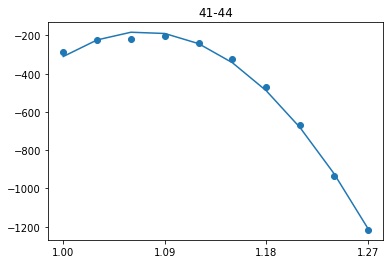

In [134]:
step = 3

start = 0
stop = -1

x_data = scales[start:stop]
y_data = np.array(lh)[start:stop]

fit = np.polyfit(x_data, y_data, 2)
f = np.poly1d(fit)

plt.scatter(x_data,y_data)
plt.plot(x_data,f(x_data))

plt.xticks(x_data[::step])

plt.title('{}-{}'.format(time1-53, time2-53))
plt.show()

In [135]:
evaluate = np.arange(scales[0], scales[-1], 0.01)
x = np.around(evaluate[f(evaluate).argmax()], 2)

#x = scale2_backup[time1]
#x = 1.07

for ww in np.arange(time1, weeks[-1]+1):
    scale2[ww] = x
print(time1-53, time2-53, x)

41 44 1.07


In [136]:
n_runs = 5

time1=53+44
time2=53+48

In [137]:
t_stop = len(H_adm_cut[H_adm_cut['abs_week']<=time2])

scales =  np.arange(1.23,1.47,0.03)
lh=[]

for s2 in scales:
    for tt in range(time1, time2+1):
        scale2[tt]=s2
        
    casuale = random.sample(range(100), n_runs)
    like=likelihood(beta,lag,scale1,delay,scale2,x_test_a,x_test_s,time1,time2,
                   fast_code = True, ordered_run_initialization=False)
    lh.append(like)
    
    casuale = []
    print(s2,like)
    
print('best:')
a = np.array([lh])
ind = np.argmax(a, axis=None)
print(scales[ind], lh[ind])

1.23 -1730.7757013048495
1.26 -1232.4328258190599
1.29 -795.1056708899811
1.32 -564.6567861823454
1.35 -547.3131468189816
1.3800000000000001 -667.3122644133031
1.4100000000000001 -973.4106883997541
1.4400000000000002 -1560.1328588230467
best:
1.35 -547.3131468189816


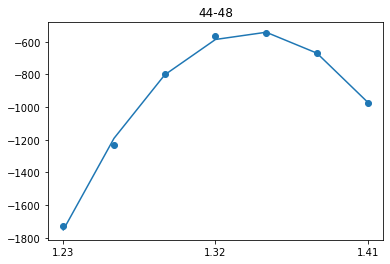

In [138]:
step = 3

start = 0
stop = -1

x_data = scales[start:stop]
y_data = np.array(lh)[start:stop]

fit = np.polyfit(x_data, y_data, 2)
f = np.poly1d(fit)

plt.scatter(x_data,y_data)
plt.plot(x_data,f(x_data))

plt.xticks(x_data[::step])
plt.title('{}-{}'.format(time1-53, time2-53))

plt.show()

In [139]:
evaluate = np.arange(scales[0], scales[-1], 0.01)
x = np.around(evaluate[f(evaluate).argmax()], 2)

#x = 1.34
#x = scale2_backup[time1]

for ww in np.arange(time1, weeks[-1]+1):
    scale2[ww] = x
print(time1-53, time2-53, x)

44 48 1.34


In [140]:
n_runs = 5

time1=53+48
time2=53+51

In [141]:
t_stop = len(H_adm_cut[H_adm_cut['abs_week']<=time2])

scales = np.arange(0.93,1.23,0.03)
lh=[]

for s2 in scales:
    for tt in range(time1, time2+1):
        scale2[tt]=s2
    casuale = random.sample(range(100), n_runs)
    like=likelihood(beta,lag,scale1,delay,scale2,x_test_a,x_test_s,time1,time2,
                   fast_code = True, ordered_run_initialization=False)
    lh.append(like)
    print(s2,like)
    
    casuale = []
    
print('best:')

a = np.array([lh])
ind = np.argmax(a, axis=None)
print(scales[ind], lh[ind])

0.93 -1457.0932711872783
0.9600000000000001 -953.549400743319
0.9900000000000001 -523.8599115808347
1.02 -432.11209628110373
1.0500000000000003 -455.7714919161963
1.08 -622.611089232144
1.1100000000000003 -863.2320829652781
1.1400000000000001 -1735.4091402656031
1.1700000000000004 -2453.6007571203563
1.2000000000000002 -3534.7149276852697
best:
1.02 -432.11209628110373


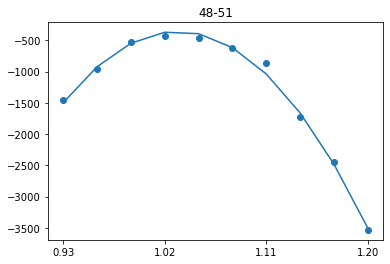

In [142]:
step = 3

x_data = scales
y_data = np.array(lh)

fit = np.polyfit(x_data, y_data, 2)
f = np.poly1d(fit)

plt.scatter(x_data,y_data)
plt.plot(x_data,f(x_data))

plt.xticks(x_data[::step])
plt.title('{}-{}'.format(time1-53, time2-53))

plt.show()

In [143]:
evaluate = np.arange(scales[0], scales[-1], 0.01)
x = np.around(evaluate[f(evaluate).argmax()], 2)

#x = 1.06
#x = scale2_backup[time1]

for ww in np.arange(time1, weeks[-1]+1):
    scale2[ww] = x
print(time1-53, time2-53, x)

48 51 1.03


In [144]:
n_runs = 5

time1=53+51
time2=53+52+1

In [149]:
t_stop = len(H_adm_cut[H_adm_cut['abs_week']<=time2])

scales = np.arange(1.0, 1.35, 0.03)
lh=[]

for s2 in scales:
    for tt in range(time1, time2+1):
        scale2[tt]=s2
        
    casuale = random.sample(range(100), n_runs)
    
    like=likelihood(beta,lag,scale1,delay,scale2,x_test_a,x_test_s,time1,time2,
                   fast_code = True, ordered_run_initialization=False)
    lh.append(like)
    print(s2,like)
    
    casuale = []
    
print('best:')
a = np.array([lh])
ind = np.argmax(a, axis=None)
print(scales[ind], lh[ind])

1.0 -1899.492184298122
1.03 -2023.194022255856
1.06 -1273.5459497615093
1.09 -984.0963986045563
1.12 -782.1059797190983
1.1500000000000001 -667.7266191252847
1.1800000000000002 -741.6160860036389
1.2100000000000002 -851.4415187291561
1.2400000000000002 -1307.113930315044
1.2700000000000002 -1371.2083702106593
1.3000000000000003 -2180.832736203408
1.3300000000000003 -2409.2203088489996
best:
1.1500000000000001 -667.7266191252847


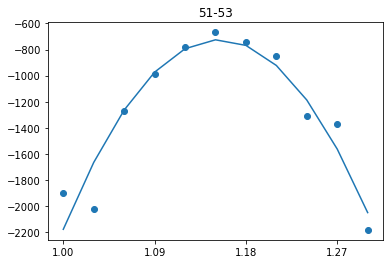

In [150]:
step = 3

start = 0
stop = -1

x_data = scales[start:stop]
y_data = np.array(lh)[start:stop]

fit = np.polyfit(x_data, y_data, 2)
f = np.poly1d(fit)

plt.scatter(x_data,y_data)
plt.plot(x_data,f(x_data))

plt.xticks(x_data[::step])
plt.title('{}-{}'.format(time1-53, time2-53))

plt.show()

In [153]:
evaluate = np.arange(scales[0], scales[-1], 0.01)
x = np.around(evaluate[f(evaluate).argmax()], 2)

#x = 1.35
#x = scale2_backup[time1]

for ww in np.arange(time1, weeks[-1]+1):
    scale2[ww] = x
print(time1-53, time2-53, x)

51 53 1.15


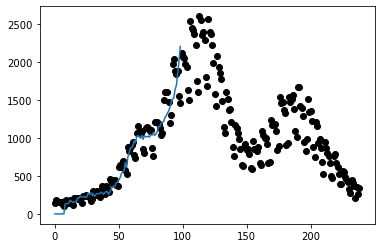

In [154]:
t_stop = len(H_adm_cut[H_adm_cut['abs_week']<=time2])

casuale = random.sample(range(100), n_runs)
    
out = run_simulation(beta,lag,intervention=True,
                  LD=[[-1,-1]],
                  scale1=scale1,scale2=scale2,
                  x_test_a=x_test_a, x_test_s=x_test_s,
                  projections = True, proj_scenario = 'none',
                  fast_code = True, ordered_run_initialization=False)
casuale = []

comp = 'new_H'

ddf = pd.DataFrame(0, index=np.arange(t_stop), columns=np.arange(n_runs))
for variant in variants:
    for past in past_infection[variant]:
        for status_vax in stati_vax:
            strain = past+variant+'_'+status_vax
            ddf += out[comp][strain].copy()

ddf = add_median_CI(ddf)
ddf['time'] = calendar.iloc[:t_stop]

plt.plot(ddf['median'])
plt.scatter(H_adm_cut.index, H_adm_cut['hosp_pred'], color='black')
plt.show()

In [155]:
time1=53+52+1
time2=53+52+4

In [156]:
n_runs = 5

t_stop = len(H_adm_cut[H_adm_cut['abs_week']<=time2])

scales = np.arange(0.5, 1.0, 0.05)
lh=[]

for s2 in scales:
    for tt in range(time1, time2+1):
        scale2[tt]=s2
    casuale = random.sample(range(100), n_runs)
    
    like=likelihood(beta,lag,scale1,delay,scale2,x_test_a,x_test_s,time1,time2,
                   fast_code = True, ordered_run_initialization=False)
    lh.append(like)
    print(s2,like)
    
    casuale = []
    
print('best:')
a = np.array([lh])
ind = np.argmax(a, axis=None)
print(scales[ind], lh[ind])

0.5 -26230.907867277718
0.55 -16852.963532056565
0.6000000000000001 -11353.190141534133
0.6500000000000001 -6627.241344638154
0.7000000000000002 -2880.9463932441413
0.7500000000000002 -1071.3340327405822
0.8000000000000003 -1097.687259737595
0.8500000000000003 -2812.066522209645
0.9000000000000004 -5491.668051988101
0.9500000000000004 -9812.117898086903
best:
0.7500000000000002 -1071.3340327405822


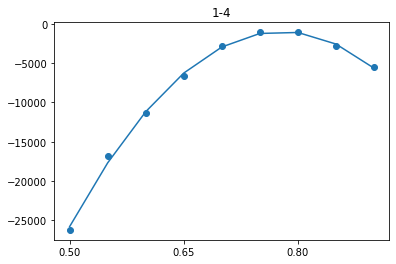

In [157]:
step = 3

start = 0
stop = -1

x_data = scales[start:stop]
y_data = np.array(lh)[start:stop]

fit = np.polyfit(x_data, y_data, 2)
f = np.poly1d(fit)

plt.scatter(x_data,y_data)
plt.plot(x_data,f(x_data))

plt.title('{}-{}'.format(time1-53-52, time2-53-52))

plt.xticks(x_data[::step])
plt.show()

In [162]:
evaluate = np.arange(scales[0], scales[-1], 0.01)
x = np.around(evaluate[f(evaluate).argmax()], 2)

#x = 0.8
#x = scale2_backup[time1]

#print(scale2_backup[time1])

for ww in np.arange(time1, weeks[-1]+1):
    scale2[ww] = x
print(time1-53-52, time2-53-52, x)

1 4 0.78


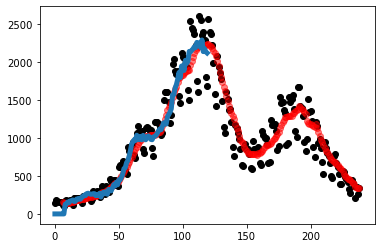

In [163]:
t_stop = len(H_adm_cut[H_adm_cut['abs_week']<=time2])

casuale = random.sample(range(100), n_runs)
    
out = run_simulation(beta,lag,intervention=True,
                  LD=[[-1,-1]],
                  scale1=scale1,scale2=scale2,
                  x_test_a=x_test_a, x_test_s=x_test_s,
                  projections = True, proj_scenario = 'none',
                  fast_code = True, ordered_run_initialization=False)
casuale = []

comp = 'new_H'

ddf = pd.DataFrame(0, index=np.arange(t_stop), columns=np.arange(n_runs))
for variant in variants:
    for past in past_infection[variant]:
        for status_vax in stati_vax:
            strain = past+variant+'_'+status_vax
            ddf += out[comp][strain].copy()

ddf = add_median_CI(ddf)
ddf['time'] = calendar.iloc[:t_stop]

plt.plot(ddf['median'], linewidth = 5)
plt.scatter(H_adm_cut.index, H_adm_cut['hosp_pred'], color='black')
plt.scatter(H_adm_cut.index, H_adm_cut['hosp_pred'].rolling(window=7).mean(), color='red', alpha = 0.5)

plt.show()

In [164]:
time1=53+52+4
time2=53+52+7

In [165]:
n_runs = 5

t_stop = len(H_adm_cut[H_adm_cut['abs_week']<=time2])

scales = np.arange(0.6, 0.9, 0.03)
lh=[]

for s2 in scales:
    for tt in range(time1, time2+1):
        scale2[tt]=s2
        
    casuale = random.sample(range(100), n_runs)
    
    like=likelihood(beta,lag,scale1,delay,scale2,x_test_a,x_test_s,time1,time2,
                   fast_code = True, ordered_run_initialization=False)
    lh.append(like)
    print(s2,like)
    
    casuale = []
    
print('best:')
a = np.array([lh])
ind = np.argmax(a, axis=None)
print(scales[ind], lh[ind])

0.6 -6890.821379223003
0.63 -5084.909845606352
0.66 -3789.323943731226
0.6900000000000001 -2537.46412891626
0.7200000000000001 -1827.4387052273833
0.7500000000000001 -993.7177957129616
0.7800000000000001 -746.9457219558744
0.8100000000000002 -799.3511579841443
0.8400000000000002 -1219.8018535498222
0.8700000000000002 -1763.188375640956
0.9000000000000002 -3691.0587830471814
best:
0.7800000000000001 -746.9457219558744


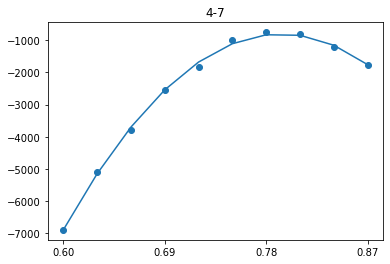

In [166]:
step = 3

start = 0
stop = -1

x_data = scales[start:stop]
y_data = np.array(lh)[start:stop]

fit = np.polyfit(x_data, y_data, 2)
f = np.poly1d(fit)

plt.scatter(x_data,y_data)
plt.plot(x_data,f(x_data))

plt.xticks(x_data[::step])

plt.title('{}-{}'.format(time1-53-52, time2-53-52))

plt.show()

In [167]:
evaluate = np.arange(scales[0], scales[-1], 0.01)
x = np.around(evaluate[f(evaluate).argmax()], 2)

#x = 0.76
#x = scale2_backup[time1]

#print(scale2_backup[time1])

for ww in np.arange(time1, weeks[-1]+1):
    scale2[ww] = x
print(time1-53-52, time2-53-52, x)

4 7 0.79


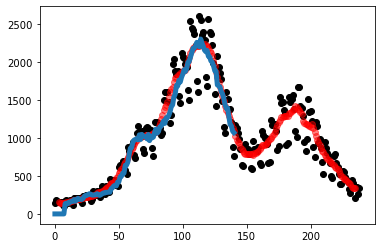

In [168]:
t_stop = len(H_adm_cut[H_adm_cut['abs_week']<=time2])

casuale = random.sample(range(100), n_runs)
    
out = run_simulation(beta,lag,intervention=True,
                  LD=[[-1,-1]],
                  scale1=scale1,scale2=scale2,
                  x_test_a=x_test_a, x_test_s=x_test_s,
                  projections = True, proj_scenario = 'none',
                  fast_code = True, ordered_run_initialization=False)
casuale = []

comp = 'new_H'

ddf = pd.DataFrame(0, index=np.arange(t_stop), columns=np.arange(n_runs))
for variant in variants:
    for past in past_infection[variant]:
        for status_vax in stati_vax:
            strain = past+variant+'_'+status_vax
            ddf += out[comp][strain].copy()

ddf = add_median_CI(ddf)
ddf['time'] = calendar.iloc[:t_stop]

plt.plot(ddf['median'], linewidth = 5)
plt.scatter(H_adm_cut.index, H_adm_cut['hosp_pred'], color='black')
plt.scatter(H_adm_cut.index, H_adm_cut['hosp_pred'].rolling(window=7, center=True).mean(), 
            color='red', alpha = 0.5)

plt.show()

In [169]:
n_runs = 5

time1=53+52+7
time2=53+52+11

In [170]:
t_stop = len(H_adm_cut[H_adm_cut['abs_week']<=time2])

scales = np.arange(0.8,1.0,0.03)
lh=[]

for s2 in scales:
    for tt in range(time1, time2+1):
        scale2[tt]=s2
    casuale = random.sample(range(100), n_runs)
    
    like=likelihood(beta,lag,scale1,delay,scale2,x_test_a,x_test_s,time1,time2,
                   fast_code = True, ordered_run_initialization=False)
    lh.append(like)
    print(s2,like)
    
    casuale = []
    
print('best:')
a = np.array([lh])
ind = np.argmax(a, axis=None)
print(scales[ind], lh[ind])

0.8 -998.9649382507982
0.8300000000000001 -696.0454066786087
0.8600000000000001 -893.5988847092312
0.8900000000000001 -1225.3258745233052
0.9200000000000002 -2552.6460734569746
0.9500000000000002 -4719.321669301247
0.9800000000000002 -6593.56229919908
best:
0.8300000000000001 -696.0454066786087


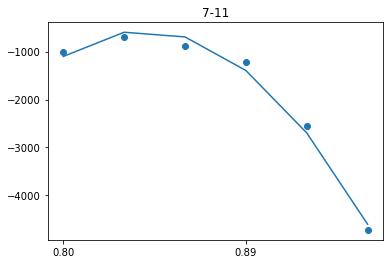

In [171]:
step = 3

start = 0
stop = -1

x_data = scales[start:stop]
y_data = np.array(lh)[start:stop]

fit = np.polyfit(x_data, y_data, 2)
f = np.poly1d(fit)

plt.scatter(x_data,y_data)
plt.plot(x_data,f(x_data))

plt.xticks(x_data[::step])

plt.title('{}-{}'.format(time1-53-52, time2-53-52))

plt.show()

In [172]:
evaluate = np.arange(scales[0], scales[-1], 0.01)
x = np.around(evaluate[f(evaluate).argmax()], 2)

#x = 0.9
#x = scale2_backup[time1]

#print(scale2_backup[time1])

for ww in np.arange(time1, weeks[-1]+1):
    scale2[ww] = x
print(time1-53-52, time2-53-52, x)

7 11 0.84


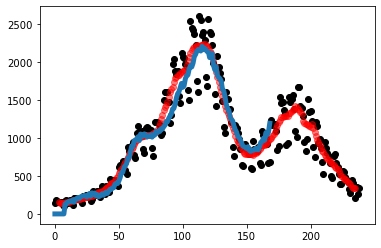

In [173]:
t_stop = len(H_adm_cut[H_adm_cut['abs_week']<=time2])

casuale = random.sample(range(100), n_runs)
    
out = run_simulation(beta,lag,intervention=True,
                  LD=[[-1,-1]],
                  scale1=scale1,scale2=scale2,
                  x_test_a=x_test_a, x_test_s=x_test_s,
                  projections = True, proj_scenario = 'none',
                  fast_code = True, ordered_run_initialization=False)
casuale = []

comp = 'new_H'

ddf = pd.DataFrame(0, index=np.arange(t_stop), columns=np.arange(n_runs))
for variant in variants:
    for past in past_infection[variant]:
        for status_vax in stati_vax:
            strain = past+variant+'_'+status_vax
            ddf += out[comp][strain].copy()

ddf = add_median_CI(ddf)
ddf['time'] = calendar.iloc[:t_stop]

plt.plot(ddf['median'], linewidth = 5)
plt.scatter(H_adm_cut.index, H_adm_cut['hosp_pred'], color='black')
plt.scatter(H_adm_cut.index, H_adm_cut['hosp_pred'].rolling(window=7, center=True).mean(), 
            color='red', alpha = 0.5)

plt.show()

In [174]:
n_runs = 5

time1=53+52+11
time2=53+52+14

In [175]:
t_stop = len(H_adm_cut[H_adm_cut['abs_week']<=time2])

scales = np.arange(0.6,0.9,0.03)
lh=[]

for s2 in scales:
    for tt in range(time1, time2+1):
        scale2[tt]=s2
    casuale = random.sample(range(100), n_runs)
    
    like=likelihood(beta,lag,scale1,delay,scale2,x_test_a,x_test_s,time1,time2,
                   fast_code = True, ordered_run_initialization=False)
    lh.append(like)
    print(s2,like)
    
    casuale = []
    
print('best:')
a = np.array([lh])
ind = np.argmax(a, axis=None)
print(scales[ind], lh[ind])

0.6 -7938.009224023487
0.63 -5156.998741928632
0.66 -3988.2513289558365
0.6900000000000001 -2907.602158743429
0.7200000000000001 -1526.618640399378
0.7500000000000001 -812.8877363334423
0.7800000000000001 -1039.2679055997987
0.8100000000000002 -1374.7352475167927
0.8400000000000002 -2695.3135014028667
0.8700000000000002 -3875.2187799514522
0.9000000000000002 -6116.135023196035
best:
0.7500000000000001 -812.8877363334423


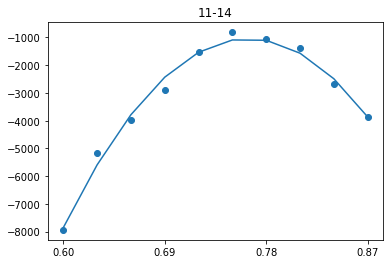

In [176]:
step = 3

start = 0
stop = -1

x_data = scales[start:stop]
y_data = np.array(lh)[start:stop]

fit = np.polyfit(x_data, y_data, 2)
f = np.poly1d(fit)

plt.scatter(x_data,y_data)
plt.plot(x_data,f(x_data))

plt.xticks(x_data[::step])

plt.title('{}-{}'.format(time1-53-52, time2-53-52))

plt.show()

In [177]:
evaluate = np.arange(scales[0], scales[-1], 0.01)
x = np.around(evaluate[f(evaluate).argmax()], 2)

#x = 0.72
#x = scale2_backup[time1]

#print(scale2_backup[time1])

for ww in np.arange(time1, weeks[-1]+1):
    scale2[ww] = x
print(time1-53-52, time2-53-52, x)

11 14 0.76


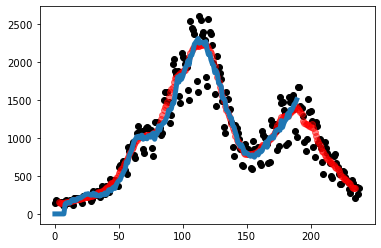

In [178]:
t_stop = len(H_adm_cut[H_adm_cut['abs_week']<=time2])

casuale = random.sample(range(100), n_runs)
    
out = run_simulation(beta,lag,intervention=True,
                  LD=[[-1,-1]],
                  scale1=scale1,scale2=scale2,
                  x_test_a=x_test_a, x_test_s=x_test_s,
                  projections = True, proj_scenario = 'none',
                  fast_code = True, ordered_run_initialization=False)
casuale = []

comp = 'new_H'

ddf = pd.DataFrame(0, index=np.arange(t_stop), columns=np.arange(n_runs))
for variant in variants:
    for past in past_infection[variant]:
        for status_vax in stati_vax:
            strain = past+variant+'_'+status_vax
            ddf += out[comp][strain].copy()

ddf = add_median_CI(ddf)
ddf['time'] = calendar.iloc[:t_stop]

plt.plot(ddf['median'], linewidth = 5)
plt.scatter(H_adm_cut.index, H_adm_cut['hosp_pred'], color='black')
plt.scatter(H_adm_cut.index, H_adm_cut['hosp_pred'].rolling(window=7, center=True).mean(), 
            color='red', alpha = 0.5)

plt.show()

In [179]:
n_runs = 5

time1=53+52+14
time2=53+52+20

In [180]:
t_stop = len(H_adm_cut[H_adm_cut['abs_week']<=time2])

scales = np.arange(0.5,0.8,0.05)
lh=[]

for s2 in scales:
    for tt in range(time1, time2+1):
        scale2[tt]=s2
    casuale = random.sample(range(100), n_runs)
    
    like=likelihood(beta,lag,scale1,delay,scale2,x_test_a,x_test_s,time1,time2,
                   fast_code = True, ordered_run_initialization=False)
    lh.append(like)
    print(s2,like)
    
    casuale = []
    
print('best:')
a = np.array([lh])
ind = np.argmax(a, axis=None)
print(scales[ind], lh[ind])

0.5 -21371.321787847937
0.55 -12089.627372127019
0.6000000000000001 -5178.385647471011
0.6500000000000001 -1820.4851792468191
0.7000000000000002 -1396.9882201981015
0.7500000000000002 -4353.948904909319
0.8000000000000003 -10407.824128001308
best:
0.7000000000000002 -1396.9882201981015


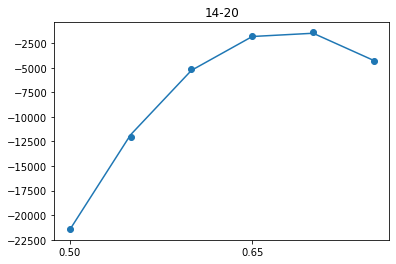

In [181]:
step = 3

start = 0
stop = -1

x_data = scales[start:stop]
y_data = np.array(lh)[start:stop]

fit = np.polyfit(x_data, y_data, 2)
f = np.poly1d(fit)

plt.scatter(x_data,y_data)
plt.plot(x_data,f(x_data))

plt.xticks(x_data[::step])

plt.title('{}-{}'.format(time1-53-52, time2-53-52))

plt.show()

In [182]:
evaluate = np.arange(scales[0], scales[-1], 0.01)
x = np.around(evaluate[f(evaluate).argmax()], 2)

#x = 0.64
#x = scale2_backup[time1]

for ww in np.arange(time1, weeks[-1]+1):
    scale2[ww] = x
print(time1-53-52, time2-53-52, x)

14 20 0.68


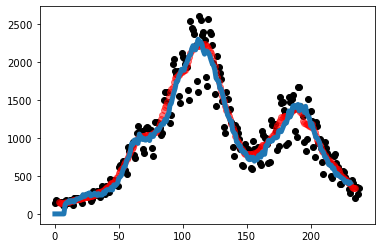

In [183]:
t_stop = len(H_adm_cut[H_adm_cut['abs_week']<=time2])

casuale = random.sample(range(100), n_runs)
    
out = run_simulation(beta,lag,intervention=True,
                  LD=[[-1,-1]],
                  scale1=scale1,scale2=scale2,
                  x_test_a=x_test_a, x_test_s=x_test_s,
                  projections = True, proj_scenario = 'none',
                  fast_code = True, ordered_run_initialization=False)
casuale = []

comp = 'new_H'

ddf = pd.DataFrame(0, index=np.arange(t_stop), columns=np.arange(n_runs))
for variant in variants:
    for past in past_infection[variant]:
        for status_vax in stati_vax:
            strain = past+variant+'_'+status_vax
            ddf += out[comp][strain].copy()

ddf = add_median_CI(ddf)
ddf['time'] = calendar.iloc[:t_stop]

plt.plot(ddf['median'], linewidth = 5)
plt.scatter(H_adm_cut.index, H_adm_cut['hosp_pred'], color='black')
plt.scatter(H_adm_cut.index, H_adm_cut['hosp_pred'].rolling(window=7, center=True).mean(), 
            color='red', alpha = 0.5)

plt.show()

# choose final date of the simulation

In [51]:
t_stop = calendar[calendar[0]=='2022-05-23'].index[0] 
t_stop 

232

# save scaling factors

In [189]:
df=pd.DataFrame(scale2.values())
df.columns=['scaling_exit']
df['week']=scale2.keys()
df['week-53'] = df['week']-53
df['test_s']= list(x_test_s.values())
df['test_a']= list(x_test_a.values())

df[df['week']<=time2].to_csv('./../input/scaling_test_fitw72_exact-daily-doses-par-residence_effective-BA2.csv',
                                                                                                index=None) #input

# run simulation and save output

In [52]:
last_week_fit = 53+72
last_week_fit2 = str(last_week_fit-53)

df = pd.read_csv('./../input/scaling_test_fitw72_exact-daily-doses-par-residence_effective-BA2.csv')

x_test_s = dict(zip(df['week'],df['test_s']))
x_test_a = dict(zip(df['week'],df['test_a']))
scale2 = dict(zip(df['week'],df['scaling_exit']))

In [53]:
n_runs = 5
 
start_time = time.time()

out = run_simulation(beta,lag,intervention=True,
                          LD=[[-1,-1]],
                          scale1=scale1,scale2=scale2,
                          x_test_a=x_test_a, x_test_s=x_test_s,
                          projections = True, proj_scenario = 'none', 
                          fast_code = False, ordered_run_initialization = True)

print("--- %s seconds ---" % (time.time() - start_time))

--- 16.72404718399048 seconds ---


In [190]:
n_runs = 100
 
start_time = time.time()

out = run_simulation(beta,lag,intervention=True,
                          LD=[[-1,-1]],
                          scale1=scale1,scale2=scale2,
                          x_test_a=x_test_a, x_test_s=x_test_s,
                          projections = True, proj_scenario = 'none', 
                          fast_code = False, ordered_run_initialization = True)

print("--- %s seconds ---" % (time.time() - start_time))

--- 851.9295148849487 seconds ---


In [57]:
dates = calendar[0].apply(lambda x: x.strftime('%Y-%m-%d'))

In [58]:
folder = "./../output"

In [59]:
comp_keys = ['new_H']

for c in range(len(comp_keys)):
    for variant in variants:
        ddf = pd.DataFrame(0, index=np.arange(t_stop), columns=np.arange(n_runs))
        for past in past_infection[variant]:
            for status_vax in stati_vax:
                strain = past+variant+'_'+status_vax
                ddf += out[comp_keys[c]][strain].copy()
        ddf = add_median_CI(ddf)
        ddf['time'] = calendar.iloc[:t_stop]
        ddf.to_csv('{}/{}_{}_scenario_{}_runs{}_{}_both.csv'.format(folder, comp_keys[c], reg, 'fit', n_runs, variant))
        
for c in range(len(comp_keys)):
    ddf = pd.DataFrame(0, index=np.arange(t_stop), columns=np.arange(n_runs))
    for variant in variants:
        for past in past_infection[variant]:
            for status_vax in stati_vax:
                strain = past+variant+'_'+status_vax
                ddf += out[comp_keys[c]][strain].copy()
    ddf = add_median_CI(ddf)
    ddf['time'] = calendar.iloc[:t_stop]
    ddf.to_csv('{}/{}_{}_scenario_{}_runs{}_{}.csv'.format(folder, 
                                    comp_keys[c], reg, 'fit', n_runs, 'both_both'))

# plot results

In [60]:
def add_median_CI2(DF):
    df = DF.copy()
    df['p1'] = df[[str(i) for i in range(n_runs)]].quantile(0.025, axis=1)
    df['median'] = df[[str(i) for i in range(n_runs)]].median(axis=1)  
    df['p2'] = df[[str(i) for i in range(n_runs)]].quantile(0.975, axis=1)
    return df

def add_median_CI(DF):
    df = DF.copy()
    df['p1'] = df[[i for i in range(n_runs)]].quantile(0.025, axis=1)
    df['median'] = df[[i for i in range(n_runs)]].median(axis=1)  
    df['p2'] = df[[i for i in range(n_runs)]].quantile(0.975, axis=1)
    return df

def aggregate_week(DF):
    y = DF.copy()
    y['date']=pd.to_datetime(y['time'],format='%Y-%m-%d')
    y = y.resample('W', on='date').sum() 
    y = y.reset_index()
    y2 = add_median_CI2(y)
    y2['week']=y2['date'].dt.isocalendar().week
    return y2

In [61]:
colors=["#264653","#e76f51","#90be6d","#264653","#e76f51","#90be6d"]

In [62]:
idx1=0
width=2

c_w5='#e8e8e4'
c_w6='lightgrey'

In [64]:
df = pd.read_csv('{}/new_H_{}_scenario_fit_runs{}_both_both.csv'.format(folder, codice_regione, n_runs))

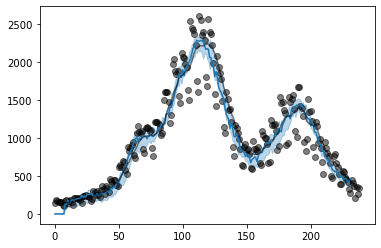

In [65]:
comp = 'new_H'

ddf = pd.DataFrame(0, index=np.arange(t_stop), columns=np.arange(n_runs))
for variant in variants:
    for past in past_infection[variant]:
        for status_vax in stati_vax:
            strain = past+variant+'_'+status_vax
            ddf += out[comp][strain].copy()

ddf = add_median_CI(ddf)
ddf['time'] = calendar.iloc[:t_stop]

plt.plot(ddf['median'])
plt.fill_between(ddf.index, ddf['p1'].values, ddf['p2'].values,color='tab:blue', alpha=0.3)  
plt.scatter(H_adm_cut.index, H_adm_cut['hosp_pred'], color='black', alpha=0.5)
plt.plot(H_adm_cut.index, H_adm_cut['hosp_pred'].rolling(window=7).mean(), color='black', alpha=0.5)

plt.show()

# extract configuration

In [74]:
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [75]:
ddf = pd.DataFrame({})
for kk in out['prev_comp'].keys():
    ddf[kk] = add_median_CI(out['prev_comp'][kk])['median']
    
ddf['time'] = calendar.iloc[:t_stop]

ddf.to_csv('{}/{}_{}_scenario_{}_runs{}.csv'.format(folder, 'median-prevalence-config', 
                                                       reg, 'fit', n_runs), index=False)

In [76]:
days_to_extract = calendar[calendar[0]>='2022-01-09'][:30][0].apply(lambda x: x.strftime('%Y-%m-%d')).values
days_to_extract

array(['2022-01-09', '2022-01-10', '2022-01-11', '2022-01-12',
       '2022-01-13', '2022-01-14', '2022-01-15', '2022-01-16',
       '2022-01-17', '2022-01-18', '2022-01-19', '2022-01-20',
       '2022-01-21', '2022-01-22', '2022-01-23', '2022-01-24',
       '2022-01-25', '2022-01-26', '2022-01-27', '2022-01-28',
       '2022-01-29', '2022-01-30', '2022-01-31', '2022-02-01',
       '2022-02-02', '2022-02-03', '2022-02-04', '2022-02-05',
       '2022-02-06', '2022-02-07'], dtype=object)

In [77]:
for day in days_to_extract:
    
    res = {}
    for kk in out['prev_comp'].keys():
        res[kk] = out['prev_comp'][kk].iloc[calendar[calendar[0]==day].index[0]]
    
    pd.DataFrame(res).to_csv('./{}/config_{}.csv'.format(folder,day), index=False)